# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [46]:
# import libraries here; add more as necessary
import collections
import gc
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import os
# os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans


import plotting
import utils

# uncomment these three lines during development to reload utils without restarting kernel
import importlib
importlib.reload(utils)
importlib.reload(plotting)
from utils import build_column_to_missing_and_unkown_values, set_missing_and_unknown_to_nan, \
        get_missing_value_counts, get_nan_correlation_df, build_column_to_data_type, get_unique_values_df, \
        get_praegende_jugendjahre_features, check_cleaned_df, clean_data, get_pca_components_df, \
        get_cluster_counts_comparison_df, get_centroids
from plotting import plot_correlation_heatmap, plot_correlation_clustermap, plot_comparison_by_unique_value, \
        plot_comparison_by_histogram, plot_pca_component_importance, plot_pca_components_heatmap, \
        plot_single_pca_component_bargraph


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [ ]:
# Load in the general demographics data.
df_demographics = pd.read_csv("data/Udacity_AZDIAS_Subset.csv", delimiter=";")

# Load in the feature summary file.
df_feature_summary = pd.read_csv("data/AZDIAS_Feature_Summary.csv", delimiter=";")

In [ ]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
display(df_demographics.describe())
display(df_demographics.info())
display(df_demographics.head())
display(df_demographics.tail())

In [ ]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

display(df_feature_summary.describe())
display(df_feature_summary.info())
display(df_feature_summary.head())
display(df_feature_summary.tail())

print(f"unique information_level: {df_feature_summary['information_level'].unique()}")
print(f"unique type: {df_feature_summary['type'].unique()}")
print(f"unique missing_or_unknown: {df_feature_summary['missing_or_unknown'].unique()}")

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [ ]:
# build a helper dictionary that maps from column name to a list of values (of
# the correct type) that are missing or unknown for that column
column_to_missing_and_unkown_values = build_column_to_missing_and_unkown_values(df_feature_summary)

# display part of the dictionary
for n, (column, missing_and_unknown_values) in enumerate(column_to_missing_and_unkown_values.items()):
    if n == 5:
        break
    print(f"{column.ljust(25)}{missing_and_unknown_values}")

In [ ]:
# Identify missing or unknown data values and convert them to NaNs.
importlib.reload(utils)
from utils import set_missing_and_unknown_to_nan
df_demographics_nans_added = set_missing_and_unknown_to_nan(df_demographics, column_to_missing_and_unkown_values)

In [ ]:
# Quick check to see the impact on the data set - only display top 20 rows
df_counts_orig = get_missing_value_counts(df_demographics)
df_counts_orig.rename(columns={"count_with_nans" : "orig_count_with_nans"}, inplace=True)
df_counts_new = get_missing_value_counts(df_demographics_nans_added)
df_counts_new.rename(columns={"count_with_nans" : "new_count_with_nans"}, inplace=True)

df_nan_count_difference = pd.merge(df_counts_orig[["column", "orig_count_with_nans"]], df_counts_new[["column", "new_count_with_nans"]], on="column", how="left")
display(df_nan_count_difference[:20])

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [ ]:
# Perform an assessment of how much missing data there is in each column of the dataset.
df_counts = get_missing_value_counts(df_demographics_nans_added)
df_counts.sort_values(by="frac_with_nans", ascending=False, inplace=True)
display(df_counts.head(15))

In [ ]:
# plot the distribution of missing/unknown values
# Note the six outliers outliers with > 20% of their data missing/unknown.  Looking at the dataframe above
# we can identify these columns as: TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH
_, ax = plt.subplots()
ax.hist(df_counts["frac_with_nans"], bins=20)
ax.set_title("Distribution of fraction of missing values")
ax.set_xlabel("fraction missing/unknonwn values")
ax.set_ylabel("count")

In [ ]:
# plot missing/unknown values by column name
_, ax = plt.subplots(figsize=(9, 16))
ax = sns.barplot(df_counts, y="column", x="frac_with_nans", ax=ax)
ax.set_title("fraction missing / unknown data", fontsize=20)
ax.set_ylabel("")
ax.set_xlabel("")

##### Investigate patterns in the amount of missing data in each column

In [ ]:
importlib.reload(plotting)
from plotting import plot_correlation_heatmap
# plot the correlation between missing/unknown data
fig, ax = plot_correlation_heatmap(df_demographics_nans_added)

In [ ]:
importlib.reload(plotting)
from plotting import plot_correlation_clustermap
# plot the correlation between missing/unknown data organized by hierarchical clustering to better understand trends
fig, ax = plot_correlation_clustermap(df_demographics_nans_added)

fig.savefig("output/clustermap-demographics_missing_or_unknown_values.png", dpi=300)

In [ ]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier_columns = ["TITEL_KZ", "AGER_TYP", "KK_KUNDENTYP", "KBA05_BAUMAX", "GEBURTSJAHR", "ALTER_HH"]
df_demographics_columns_removed = df_demographics_nans_added.drop(columns=outlier_columns)

print(f"columns before: {len(df_demographics_nans_added.columns)}")
print(f"columns after: {len(df_demographics_columns_removed.columns)}")

#### Discussion 1.1.2: Assess Missing Data in Each Column

My summary after investigating missing/unknown values in the data set.

- The columns that are outliers with the most missing data (>20%) are

| column   | Fraction missing/unknown |
| -------- | --------- |
| TITEL_KZ | 0.997576 |
| AGER_TYP | 0.769554 |
| KK_KUNDENTYP | 0.655967 |
| KBA05_BAUMAX | 0.534687 |
| GEBURTSJAHR | 0.440203 |
| ALTER_HH | 0.348137 |

- There are three groups that are positively correlated with each other, which you can see as the larger blocks of red sitting along the axis.  For example the first block (closest to bottom right of the plot) is of `LP_FAMILIE_FEIN`, `LP_FAMILIE_GROB`, `LP_LEBENSPHASE_FEIN`, `LP_LEBENSPHASE_GROB`.  When one of these colums has missing/unknown data, they all tend to.  The same is true of the two other larger clusters.  This implies that we can remove rows with NaNs without losing too much additional data (after we have remove the outlier columns).

![clustermap](output/clustermap-demographics_missing_or_unknown_values.png)


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [ ]:
# Plot the distribution for how much data is missing in each row of the dataset?
nan_count_by_row = df_demographics_columns_removed.isna().sum(axis=1).values

max_nan = nan_count_by_row.max()
cutoff = 0
print(f"number of columns: {len(df_demographics_columns_removed.columns)}")
print(f"max number of NaN values in a row: {max_nan}")

fig, ax = plt.subplots()
counts, bins, bar = ax.hist(nan_count_by_row, bins=np.arange(-0.5, max_nan + 0.5, 1.0))
ax.plot([cutoff+0.6, cutoff+0.6], [0, counts.max()], "--", label="cutoff")
#ax.set_title("Distribution of missing/unknown values in row")
ax.set_xlabel("missing / unknown values in a row", fontsize=16)
ax.set_ylabel("count", fontsize=16)
ax.legend()

output_file_path = os.path.join("output", "missing_and_unknown_values_distribution.png")
fig.savefig(output_file_path, dpi=300)

In [ ]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
df_keeping = df_demographics_columns_removed.iloc[nan_count_by_row<=cutoff]
df_dropping = df_demographics_columns_removed.iloc[nan_count_by_row>cutoff]

print(f"len(df_keeping): {len(df_keeping)}")
print(f"len(df_dropping): {len(df_dropping)}")
print(f"len(df_demographics_columns_removed): {len(df_demographics_columns_removed)}")

In [ ]:
# remove any columns that now are identically a single value after the NaN rows have been removed
columns_to_drop = []
for column in df_keeping.columns:
    unique_values = df_keeping[column].unique().tolist()
    if len(unique_values) == 1:
        columns_to_drop.append(column)

print(f"dropping {len(columns_to_drop)} columns: {columns_to_drop}")
if len(columns_to_drop) > 0:
    df_keeping = df_keeping.drop(columns=columns_to_drop)

Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.

In [ ]:
# display the fraction of missing values in df_demographics_columns_removed by column to help
# with selecting columns
df_counts = get_missing_value_counts(df_demographics_columns_removed)
df_counts.sort_values(by="frac_with_nans", ascending=True, inplace=True)
display(df_counts.head(50))

In [ ]:
# Selected columns for which to generate comparison plots.  These were chosen to represent the different
# data types while keeping the amount of missing data reasonable.
# selected types: categorical, categorical, ordinal, numeric, mixed, 
selected_columns = ["ZABEOTYP", "GREEN_AVANTGARDE", "SEMIO_REL", "ANZ_PERSONEN", "WOHNLAGE"]
df_counts[df_counts["column"].isin(selected_columns)]

In [ ]:
# inspect the set of data to see how many unique values each column has.  This will help guide
# how best to visualize comparisons.
column_to_data_type = build_column_to_data_type(df_feature_summary)
df_unique_values = get_unique_values_df(df_demographics_columns_removed, column_to_data_type)
df_unique_values.sort_values(by="num_unique_values", ascending=False, inplace=True)

display(df_unique_values.head(15))

From this insepection, it seems like we should be able to generate a bar plot for every unique value for all columns except for two numeric columns: `KBA13_ANZAHL_PKW` and `ANZ_HAUSHALTE_AKTIV`.  For these, we will need to generate histograms for visualization.

In [ ]:
# display comparison plots for the selected columns
importlib.reload(plotting)
from plotting import plot_comparison_by_unique_value, plot_comparison_by_histogram
for column in selected_columns:
    fig, ax = plt.subplots()
    ax = plot_comparison_by_unique_value(df_keeping, df_dropping, column, ax=ax)

# plot one of the larger numeric columns
fig, ax = plt.subplots()
ax = plot_comparison_by_histogram(df_keeping, df_dropping, "KBA13_ANZAHL_PKW", ax=ax)

In [ ]:
# run comparison for all columns and save images to file
display(df_unique_values.head(5))
for _, row in df_unique_values.iterrows():
    fig, ax = plt.subplots()
    column = row["column"]
    data_type = row["data_type"]
    num_unique_values = row["num_unique_values"]
    if data_type == "numeric":
        if num_unique_values > 20:
            ax = plot_comparison_by_histogram(df_keeping, df_dropping, column, ax=ax)
        else:
            ax = plot_comparison_by_unique_value(df_keeping, df_dropping, column, ax=ax)
    else:
        ax = plot_comparison_by_unique_value(df_keeping, df_dropping, column, ax=ax)

    output_file_name = f"comparison-{column}.png"
    output_file_path = os.path.join("output", output_file_name)
    fig.savefig(output_file_path, dpi=300)
    plt.close()

In [ ]:
268012 / 891221

#### Discussion 1.1.3: Assess Missing Data in Each Row

The majority of rows have zero NaNs, but there are some outlier rows as can be seen in the distribution below.

<img src="output/missing_and_unknown_values_distribution.png" width="600"/>

I have chosen to remove all rows from the analysis that have $\ge 1$ NaN for a couple reasons.  Doing this makes downstream 

For simplicity, I have decided to drop all rows that have a NaN count $\ge 1$, which is 268,012 rows (30% of the data).  An alternate strategy would be to retain more rows with some NaNs (for example $\le 5$ NaNs) and then imputed missing the missing values.  An advantage to dropping the rows is that we do not need to worry that our choice of impute method is impacting the final conclusions.  For example, what is the best impute method to replace a NaN with for the `GEBAEUDETYP` (type of building) category?  Taking an average of the value doesn't work for a categorical.  It might be ok with the one-hot encoded columns?  Or maybe taking the mode could work?  There isn't a clear choice that wouldn't need investigation as to whether the imput method was impacting the final result.  However, a disadvantage to dropping rows with NaNs is that we are losing data that is potentially useful in identifying the different demographic/customer groups.

Whenever data is removed, it is important to consider whether this will impact the final analysis and conclusions that can be drawn.  To do this, I have generated comparison plots between the data being kept and the data being discarded for each feature in the data set.  Overall, there is qualitative agreement for most features, which makes the final interpretation of the data more straightforward.  Some of the distributions are clearly not statistically equivalent and may warrant further investigation in a more in-depth analysis.

Some comparisons are shown below

<img src="output/comparison-ZABEOTYP.png" width="600"/>

<img src="output/comparison-GREEN_AVANTGARDE.png" width="600"/>

<img src="output/comparison-SEMIO_REL.png" width="600"/>

<img src="output/comparison-ANZ_PERSONEN.png" width="600"/>

<img src="output/comparison-WOHNLAGE.png" width="600"/>

<img src="output/comparison-KBA13_ANZAHL_PKW.png" width="600"/>

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [ ]:
# How many features are there of each data type?
display(df_feature_summary.head(10))
df_data_type_counts = pd.DataFrame(df_feature_summary.value_counts(subset="type")).reset_index()
display(df_data_type_counts)

In [ ]:
# How many unique values are there for each column?
column_to_data_type = build_column_to_data_type(df_feature_summary)
df_unique_values = get_unique_values_df(df_keeping, column_to_data_type)
df_unique_values.sort_values(by="num_unique_values", ascending=False, inplace=True)

display(df_unique_values.head(15))

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [ ]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
display(df_unique_values[df_unique_values["data_type"] == "categorical"])

In [ ]:
# scratchwork: verifying I understand how get_dummies works
# NOTE: how NaNs are handled.  We have dropped all NaNs and so we don't need to decide
#       whether to change the default behavior
temp_df = pd.DataFrame([[pd.NA, 0], [1, 1], [2, 0], [1, 1]], columns=["A", "B"])
display(temp_df)
display(pd.get_dummies(temp_df, columns=["A"], dtype=int))

In [ ]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Based on the table above, I will drop CAMEO_DEU_2015 since it has 44 unique values, but
# one hot encode all other categorical columns using pd.get_dummies()
df_categorical_modifications = df_keeping.copy()

# drop column "CAMEO_DEU_2015"
df_categorical_modifications = df_categorical_modifications.drop(columns=["CAMEO_DEU_2015"])

# modify column "OST_WEST_KZ" to be numerical
df_categorical_modifications["OST_WEST_KZ"] = df_categorical_modifications["OST_WEST_KZ"].apply(lambda val: 0 if val == "W" else 1)

# identify columns for one hot encoding
idx = (df_unique_values["data_type"] == "categorical") & (df_unique_values["num_unique_values"] > 2) & (df_unique_values["num_unique_values"] < 13)
columns_for_one_hot_encoding = df_unique_values[idx]["column"].tolist()
columns_for_one_hot_encoding.sort()
print(f"columns_for_one_hot_encoding: {columns_for_one_hot_encoding}")

# carry out one hot encoding on columns
df_categorical_modifications = pd.get_dummies(df_categorical_modifications, columns=columns_for_one_hot_encoding, dtype=int)

Quick checks to verify things look as expected after one hot encoding

In [ ]:
# We expect there to be 79 - 1 + 11 + 10 + 9 + 8 + 5 + 5 + 5 + 4 + 4 + 3 + 3 + 2 = 147 columns
print(f"df_categorical_modifications.shape: {df_categorical_modifications.shape}")
print(f"num columns before categorical modifications: {len(df_keeping.columns)}")
print(f"num columns after categorical modifications: {len(df_categorical_modifications.columns)}")

# we expect that column "OST_WEST_KZ" to be 0 or 1
print(f"OST_WEST_KZ column values: {df_categorical_modifications['OST_WEST_KZ'].unique()}")

# verify that the expected columns for "SHOPPER_TYP" exist (i.e. SHOPPER_TYP_0, SHOPPER_TYP_1, SHOPPER_TYP_2, SHOPPER_TYP_3)
columns = [column for column in df_categorical_modifications.columns.tolist() if column.startswith("SHOPPER_TYP")]
print(f"SHOPPER_TYP columns: {columns}")

In [ ]:
# verify that all the other binary categorical columns are numeric
for column in ["ANREDE_KZ", "VERS_TYP", "SOHO_KZ", "GREEN_AVANTGARDE"]:
    unique_values = df_keeping[column].dropna().unique().tolist()
    assert len(unique_values) == 2
    all_numeric = {type(val) for val in unique_values} - {int, float} == set()
    print(f"{column.ljust(25)}:  all values are numeric: {all_numeric} ({unique_values})")

#### Discussion 1.2.1: Re-Encode Categorical Features

Based on the table listing the number of unique values for each categorical column, I decided to drop the columns with the most values (44), but to keep and one hot encode all others (with > 2 categories) to retain as much information as possible.

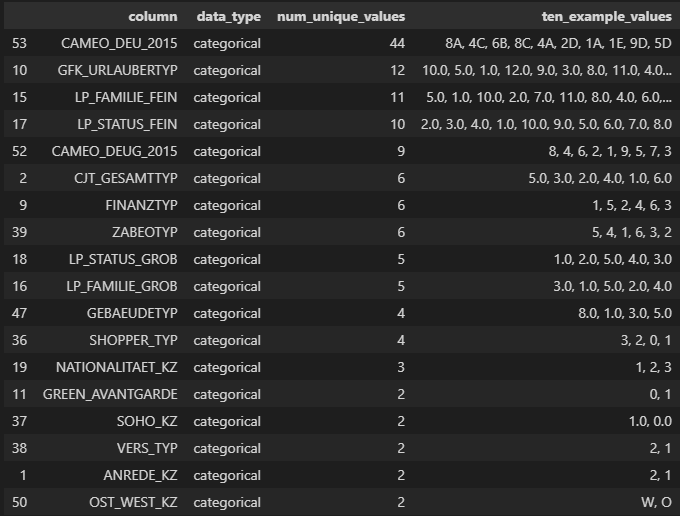

The modifications made to the data:
- dropped column "CAMEO_DEU_2015", which had 44 unique values
- modified column "OST_WEST_KZ" to have numeric values (0 if category "W" and 1 if category "O")
- one hot encoded all other categorical columns that had more than 2 categories.  Their column names was retained with a suffix of '_{val}' appended for each unique category value

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [ ]:
# Display general information on each of the "mixed" data type columns
display(df_unique_values[df_unique_values["data_type"] == "mixed"])
mixed_data_type_columns = df_unique_values[df_unique_values["data_type"] == "mixed"]["column"].tolist()
for column in mixed_data_type_columns:
    unique_values = df_categorical_modifications[column].dropna().unique().tolist()
    unique_values.sort()
    print(f"{column.ljust(20)}: {unique_values}")

In [ ]:
importlib.reload(utils)
from utils import get_praegende_jugendjahre_features, get_cameo_intl_2015_features

df_mixed_modifications = df_categorical_modifications.copy()
columns_for_one_hot_encoding = []

# Replace "PRAEGENDE_JUGENDJAHRE" with two new categorical columns: avantgarde and decade.  Drop the
# original column.  One hot encoding will be done at the end after all feature engineering has been
# completed.
#   avantgarde, decade = get_praegende_jugendjahre_features(val)

# add avantgarde column
func = lambda val: get_praegende_jugendjahre_features(val)[0]
df_mixed_modifications["avantgarde"] = df_mixed_modifications["PRAEGENDE_JUGENDJAHRE"].apply(func)

# add decade column
func = lambda val: get_praegende_jugendjahre_features(val)[1]
df_mixed_modifications["decade"] = df_mixed_modifications["PRAEGENDE_JUGENDJAHRE"].apply(func)
columns_for_one_hot_encoding.append("decade")

# drop original column
df_mixed_modifications = df_mixed_modifications.drop(columns=["PRAEGENDE_JUGENDJAHRE"])

In [ ]:
# Replace "CAMEO_INTL_2015" with two new categorical columns: wealth_category and life_stage_category.  Drop the
# original column.  One hot encoding will be done at the end after all feature engineering has been
# completed.
#   wealth_category, life_stage_category = get_cameo_intl_2015_features(value)

# add wealth_category
func = lambda val: get_cameo_intl_2015_features(val)[0]
df_mixed_modifications["wealth_category"] = df_mixed_modifications["CAMEO_INTL_2015"].apply(func)

func = lambda val: get_cameo_intl_2015_features(val)[1]
df_mixed_modifications["life_stage_category"] = df_mixed_modifications["CAMEO_INTL_2015"].apply(func)

columns_for_one_hot_encoding.extend(["wealth_category", "life_stage_category"])

# drop original column
df_mixed_modifications = df_mixed_modifications.drop(columns=["CAMEO_INTL_2015"])

In [ ]:
# Perform one hot encoding for any new categorical columns that need it
print(f"columns_for_one_hot_encoding: {columns_for_one_hot_encoding}")
df_mixed_modifications = pd.get_dummies(df_mixed_modifications, columns=columns_for_one_hot_encoding, dtype=int)

In [ ]:
# For now, drop the remaining mixed data type columns for simplicity
columns_to_drop = ["LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB", "WOHNLAGE", "PLZ8_BAUMAX"]
df_mixed_modifications = df_mixed_modifications.drop(columns=columns_to_drop)

Quick checks to verify things look as expected after one hot encoding

In [ ]:
# We expect there to be 147 - 6 + (7) + (5 + 5) = 158 columns
print(f"num columns before mixed modifications: {len(df_categorical_modifications.columns)}")
print(f"num columns after mixed modifications: {len(df_mixed_modifications.columns)}")
print(f"df_mixed_modifications.shape: {df_mixed_modifications.shape}")

# we expect that column "PRAEGENDE_JUGENDJAHRE" no longer exists, but there are the following new columns
expected_columns = {"avantgarde", "decade_0", "decade_1", "decade_2", "decade_3", "decade_4", "decade_5"}
columns_found = expected_columns - set(df_mixed_modifications.columns.tolist()) == set()
print(f"PRAEGENDE_JUGENDJAHRE column dropped: {'PRAEGENDE_JUGENDJAHRE' not in df_mixed_modifications.columns}")
print(f"replacement columns exist as expected: {columns_found}")

#### Discussion 1.2.2: Engineer Mixed-Type Features

The columns listed in the table below had a data type of "mixed".  For simplicity, I have opted to reengineer the `PRAEGENDE_JUGENDJAHRE` (*Dominating movement of person's youth*) column into two categorical features: `avantgarde` and `decade`.  I have also opted to reengineer the `CAMEO_INTL_2015` (*Wealth / Life Stage Typology*) column into two categorical features `wealth_category` and `life_stage_category`.  For simplicity, all other mixed data type columns were dropped.  Categorical features with more than 2 categories were then one hot encoded.

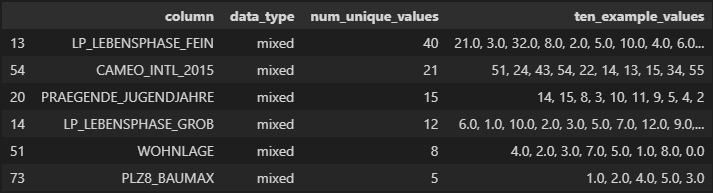

modifications made to the data:
- `PRAEGENDE_JUGENDJAHRE` column was engineered into two categorical columns: `avantgarde` and `decade`
- `CAMEO_INTL_2015` column was engineered into two categorical features `wealth_category` and `life_stage_category`
- `decade`, `wealth_category`, and `life_stage_category` were one hot encoded into new columns with  "_{val}" appended
- `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015` columns were dropped
- all other mixed data type columns were dropped (`LP_LEBENSPHASE_FEIN`, `LP_LEBENSPHASE_GROB`, `WOHNLAGE`, `PLZ8_BAUMAX`)

The final data frame is `df_mixed_modifications`

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# Check that the final cleaned dataframe meets expectations
importlib.reload(utils)
from utils import check_cleaned_df
df_cleaned = df_mixed_modifications.copy()
all_checks_passed = check_cleaned_df(df_cleaned) # raise exception if anything does not meet expected format
print(f"all_checks_passed: {all_checks_passed}")

In [ ]:
# clear out intermediate objects that are no longer needed
import gc
del df_demographics
del df_feature_summary
del df_demographics_nans_added
del df_counts_orig
del df_counts_new
del df_nan_count_difference
del df_counts
del df_demographics_columns_removed
del nan_count_by_row
del df_keeping
del df_dropping
del df_unique_values
del df_data_type_counts
del temp_df
del df_categorical_modifications
del df_mixed_modifications
gc.collect()

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [ ]:
importlib.reload(utils)
from utils import clean_data

# verify that cleaning with the function defined in utils matches what is in this notebook
reloaded_df_demographics = pd.read_csv("data/Udacity_AZDIAS_Subset.csv", delimiter=";")
reloaded_df_feature_summary = pd.read_csv("data/AZDIAS_Feature_Summary.csv", delimiter=";")
reloaded_df_cleaned = clean_data(reloaded_df_demographics, reloaded_df_feature_summary)

print(f"df_cleaned.shape: {df_cleaned.shape}")
print(f"reloaded_df_cleaned.shape: {reloaded_df_cleaned.shape}")
dataframes_are_equal = df_cleaned.equals(reloaded_df_cleaned)
print(f"dataframes_are_equal: {dataframes_are_equal}")

del reloaded_df_demographics
del reloaded_df_feature_summary
del reloaded_df_cleaned
gc.collect()

In [2]:
# Uncomment the following lines to load dataframe using the clean_data() function
df_demographics = pd.read_csv("data/Udacity_AZDIAS_Subset.csv", delimiter=";")
df_feature_summary = pd.read_csv("data/AZDIAS_Feature_Summary.csv", delimiter=";")
df_cleaned = clean_data(df_demographics, df_feature_summary)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [3]:
# Since we decided to remove all rows with >= 1 NaN, we do not need to do anything to replace NaNs

In [4]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_cleaned)

In [5]:
# do some quick checks to verify things look as expected
column_means = data_scaled.mean(axis=0)
column_stdevs = data_scaled.std(axis=0)

print(f"means are all very close to 0: {np.allclose(column_means, 0.0)}")
print(f"stdevs are all very close to 1: {np.allclose(column_stdevs, 1.0)}")

means are all very close to 0: True
stdevs are all very close to 1: True


### Discussion 2.1: Apply Feature Scaling

Since I decided to drop all rows with a NaN count $\ge 1$ in an earlier step, I do not need to do anything to impute/drop NaN values here.  I used the standard feature scaling, which sets the mean to 0 and standard deviation to 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [6]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
num_rows, num_columns = data_scaled.shape
pca = PCA(n_components=num_columns)
data_pca = pca.fit_transform(data_scaled)

/mnt/c/Users/mattp/OneDrive/Documents/Training/Udacity - Introduction to Machine Learning with TensorFlow/03 Unsupervised Learning/06 Project - Identify Customer Segments/udacity-project-creating-customer-segments/plotting.py:141: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


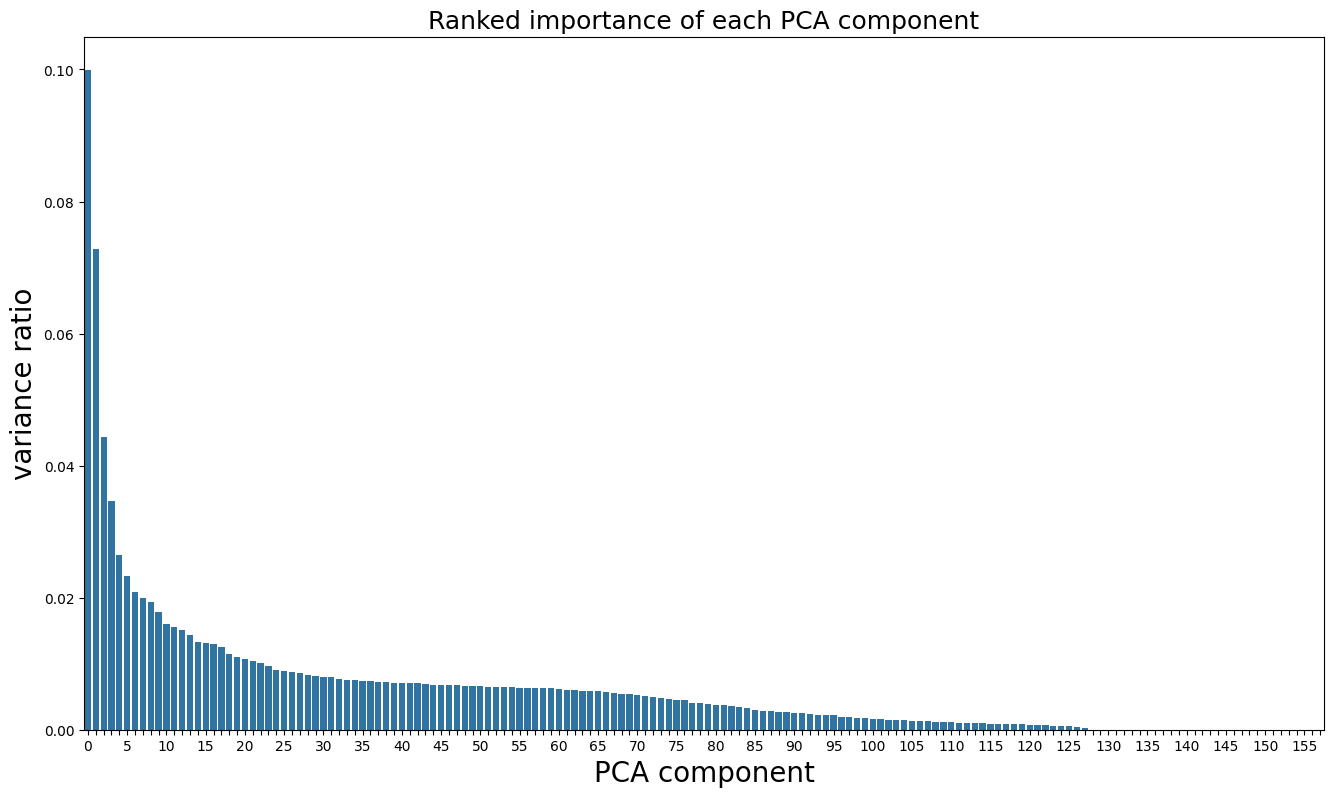

In [7]:
# Investigate the variance accounted for by each principal component.
importlib.reload(plotting)
from plotting import plot_pca_component_importance, plot_pca_component_cumulative_importance
ax = plot_pca_component_importance(pca)

# save figure to file
output_file_path = os.path.join("output", "pca-variance-ratio.png")
fig = plt.gcf()
fig.savefig(output_file_path, dpi=300)

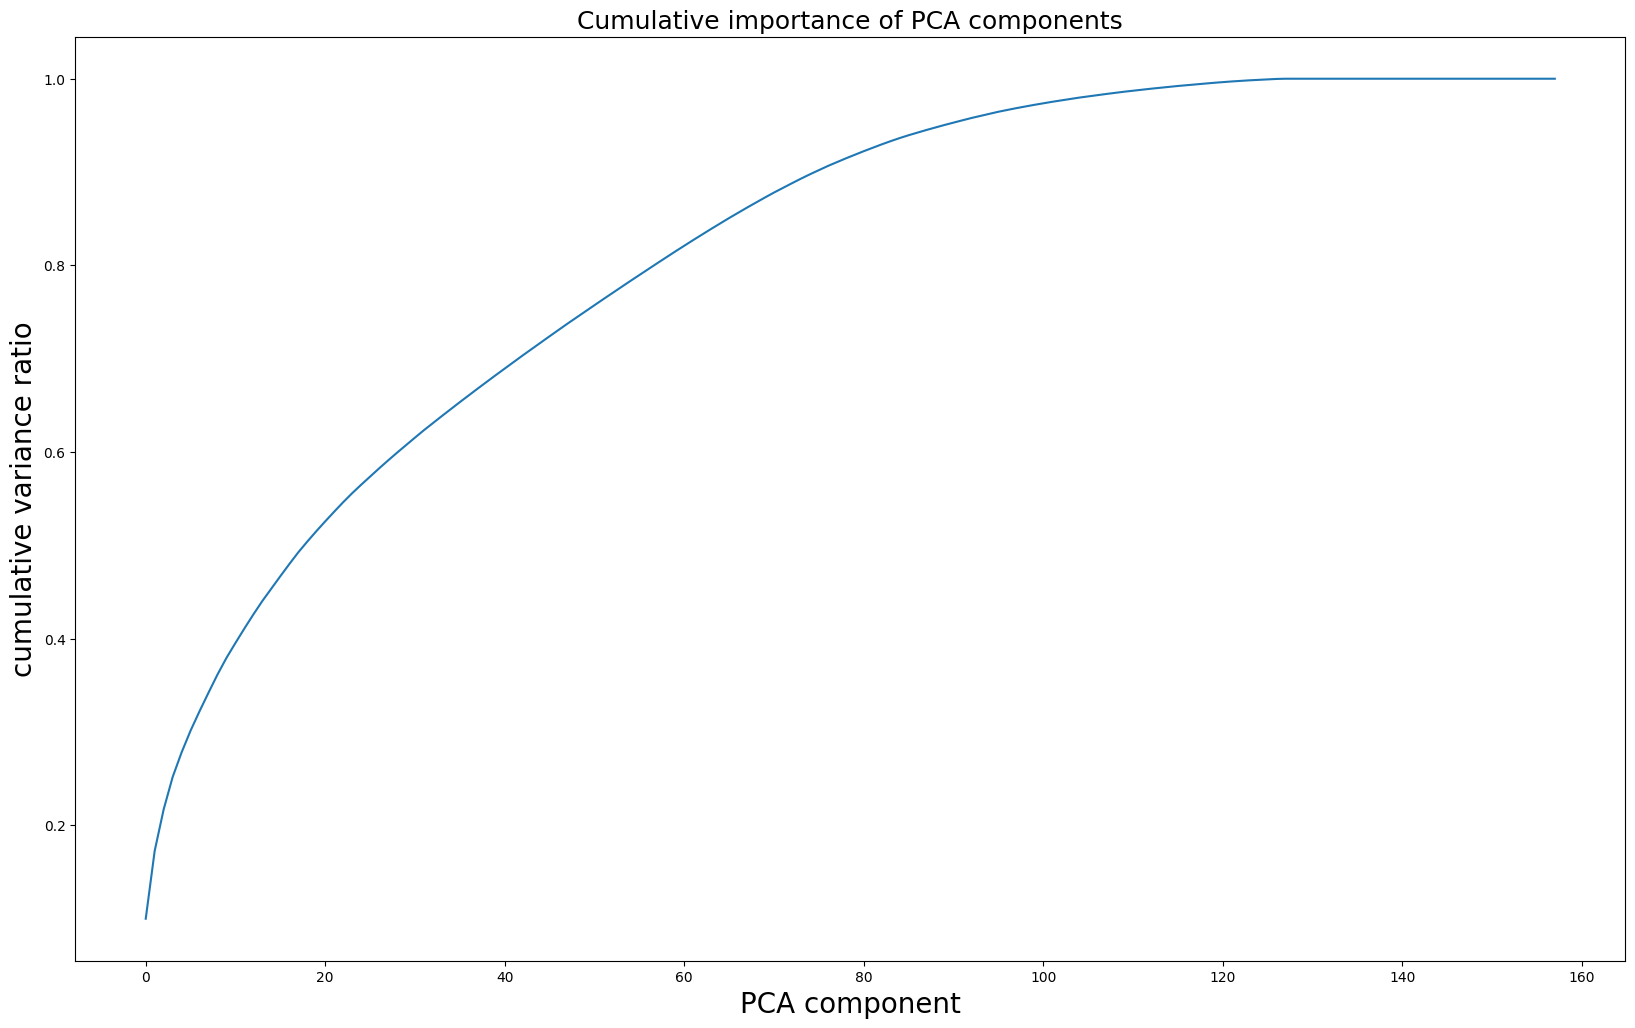

In [8]:
ax = plot_pca_component_cumulative_importance(pca)

# save figure to file
output_file_path = os.path.join("output", "pca-cumulative-variance-ratio.png")
fig = plt.gcf()
fig.savefig(output_file_path, dpi=300)

#### Some important notes on PCA

**Reproducing cluster labels**
if you want to be able to exactly match cluster labels later on in the analysis, where you use `pca.fit()` on the same scaled data input, you cannot use `fit_transform()`.  It appears to do something very slightly different under the hood which causes a very small number of points to get a slightly different PCA project and a different cluster assignment.  Quick web search seems to indicate that this is a known difference between these two different methods.  These differences seem likely to be irrelevant to the final interpretation, but, to maintain reproducability, I will use fit() and then transform() below.

**Validity of inverse_transform()**
If you would like for the `pca.inverse_transform()` to be meaningful later on, you need to retain most / all principal components.  If you retain too few principal components, the inverse transformation is quite noisy, which is to be expected if you are discarding dimensions.  This is important if you are hoping to interpret different clusters by looking at the coordinates of their centroids.  It is not important if you only look at the values for the top principal components.  **For this reason, I will plan to keep all principal components.**  This dataset is not prohibitively slow when keeping all 


Example looking at the difference between feature values for a portion of the first row when only the top 100 components are kept (which account for 97% of the variance!)
```
# abs(difference)     original_value       inverse_transform_value

0.08525261208169232  -1.8315437109314525   -1.7462910988497602
0.03994291750316481  0.9378818415836366   0.9778247590868014
0.3746324516806714  -1.8868562709083099   -1.5122238192276385
0.05905057332969199  1.522007326808236   1.581057900137928
0.2536528857728093  -0.7913893934483296   -1.045042279221139
0.05073738352238011  1.5897956016623076   1.5390582181399275
0.0329262418505023  1.0799988516313352   1.047072609780833
0.18696092185491553  1.153520821597946   1.3404817434528615
0.007528851691107619  -0.5461413469887741   -0.5536701986798818
0.12148982943327513  1.166136332251833   1.0446465028185579
0.027585881964582892  -1.6932759051875372   -1.6656900232229543
0.1225692160973057  0.26581785996614116   0.38838707606344686
0.12633811886226665  -0.16737968452863924   -0.041041565666372605
0.5369229192173208  0.5900173154919752   0.05309439627465438
0.03191893301163157  -0.3893720088375924   -0.42129094184922394
0.513800946670506  -1.1907827357787333   -1.7045836824492393
```

In [24]:
# Re-apply PCA to the data keeping the top 100 components.
pca = PCA()
#pca = PCA(n_components=100)
#data_pca = pca.fit_transform(data_scaled)
pca.fit(data_scaled)
data_pca = pca.transform(data_scaled)

cumulative_variance_ratio = np.sum(pca.explained_variance_ratio_)
print(f"cumulative variance ratio: {cumulative_variance_ratio}")

cumulative variance ratio: 1.0


### Discussion 2.2: Perform Dimensionality Reduction

I have chosen to retain the top 100 PCA components since 97% of the observed variance can be explained through them.  Plots summarizing this are shown below.

<img src="output/pca-variance-ratio.png" width="600"/>

<img src="output/pca-cumulative-variance-ratio.png" width="600"/>

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [25]:
# Build dataframe with column names added to the PCA eigenvectors
importlib.reload(utils)
from utils import get_pca_components_df
column_names = df_cleaned.columns
df_pca_components = get_pca_components_df(pca, column_names)

display(df_pca_components.head(5))

,column_name,column_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157
0,ALTERSKATEGORIE_GROB,0,-0.106840,0.224510,0.019088,-0.023704,0.040299,0.017917,0.000270,-0.001508,0.013909,0.003586,0.016435,-0.001166,0.019902,0.104084,0.010644,-0.038357,0.014882,0.010344,-0.045872,-0.091186,-0.038816,-0.070242,0.060800,-0.049390,0.000835,-0.007438,-0.037614,-0.008113,0.067632,0.049218,-0.064714,0.032954,0.015012,0.024461,0.051517,0.008067,-0.062960,0.041652,-0.049782,-0.035926,0.029388,-0.017353,0.034864,0.042220,0.016734,-0.007321,0.016800,0.046997,-0.053753,0.019864,-0.014239,-0.033883,-0.051236,0.025060,0.010392,0.007790,-0.026249,-0.006906,0.021538,-0.023005,0.029617,0.033215,0.023064,0.007146,-0.012525,-0.021094,0.020150,-0.043370,-0.064877,0.005507,0.013274,0.022310,0.033153,0.054594,0.025284,0.008142,0.014737,-0.031251,-0.034887,-0.000792,-0.094004,0.008972,-0.030471,-0.042785,0.000584,0.072675,0.066589,0.017626,-0.033373,0.031992,-0.064159,-0.066554,-0.142859,-0.038806,-0.018311,-0.103164,-0.055224,0.022774,0.038709,-0.003388,-0.053962,-0.051488,-0.010518,0.008216,0.042418,0.060788,0.029256,0.051226,-0.064194,0.121620,0.031668,-0.005861,0.063239,-0.034543,0.031130,-0.013463,-0.103190,0.073493,-0.102182,0.078837,-0.010403,0.163054,-0.180060,0.179910,0.022106,-0.380558,0.568801,0.364877,1.651168e-15,-0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00
1,ANREDE_KZ,1,0.008065,0.039557,-0.339949,0.103401,-0.020436,-0.007178,0.009861,-0.014819,0.015044,0.006315,-0.029104,0.005043,0.002808,-0.054054,-0.011211,0.025964,-0.021682,0.081831,-0.021541,0.018565,0.003539,0.021322,-0.030290,0.017533,-0.001388,-0.011894,-0.013795,-0.000894,-0.009817,-0.027483,0.012868,-0.042365,-0.005198,-0.017318,-0.008191,-0.024928,0.041173,0.012324,0.020047,0.018629,-0.005812,0.021707,0.002070,-0.009498,-0.007335,0.009989,0.012850,-0.036317,0.025143,-0.011480,0.009862,0.007458,0.012228,-0.012747,-0.009976,-0.001028,0.033705,-0.006174,0.013991,-0.000101,-0.040303,0.044978,0.008497,0.002256,-0.040065,0.036039,0.026707,0.037234,-0.018062,-0.006196,0.020372,-0.041640,-0.011013,-0.025463,-0.020948,0.001843,-0.000497,0.013844,0.020443,-0.003105,0.030899,-0.009095,0.000985,0.021930,-0.004591,-0.064231,-0.015592,-0.009133,-0.087247,0.014432,0.018620,0.006121,0.008615,0.085798,-0.026411,0.040151,0.100031,0.005586,-0.044978,-0.060567,-0.041078,0.023259,-0.003136,-0.011507,0.003522,-0.028905,-0.013501,-0.026618,0.060019,-0.095879,0.018623,-0.038900,-0.079445,0.018529,0.000836,0.013032,0.077015,-0.075284,0.101263,-0.062708,0.007377,-0.008548,0.171853,-0.037236,-0.011335,0.112085,-0.189985,0.813108,4.304257e-16,1.820194e-16,4.798589e-16,-1.071161e-16,1.397119e-16,-6.332278e-17,4.424980e-16,4.324970e-16,1.466575e-17,1.960106e-16,-8.099647e-17,5.148342e-16,1.393395e-17,1.936158e-16,-3.743173e-16,3.749623e-16,2.847154e-16,-2.479255e-16,5.383891e-17,2.685690e-16,1.287490e-17,-2.245993e-16,1.842534e-16,4.204425e-19,1.670921e-16,-2.131683e-16,-7.122376e-17,3.201073e-16,1.474375e-16,3.192425e-17
2,FINANZ_MINIMALIST,2,-0.194500,0.068372,0.128090,-0.013871,0.047856,-0.017300,-0.002186,0.067234,-0.129339,-0.023608,-0.037346,0.006801,-0.000727,-0.051996,0.012942,-0.005599,0.025345,0.0

,column_name,0
47,MOBI_REGIO,-0.200345
2,FINANZ_MINIMALIST,-0.194500
37,KBA05_ANTG1,-0.188899
41,KBA05_GBZ,-0.177462
51,PLZ8_ANTG1,-0.177027
56,PLZ8_GBZ,-0.131584
34,KONSUMNAEHE,-0.126892
122,LP_STATUS_FEIN_10.0,-0.121358
127,LP_STATUS_GROB_5.0,-0.121358
44,INNENSTADT,-0.120185


,column_name,0
114,LP_STATUS_FEIN_2.0,0.115902
52,PLZ8_ANTG2,0.116675
75,FINANZTYP_1,0.117067
113,LP_STATUS_FEIN_1.0,0.122980
40,KBA05_ANTG4,0.123437
3,FINANZ_SPARER,0.130308
7,FINANZ_HAUSBAUER,0.135980
43,EWDICHTE,0.143409
58,ORTSGR_KLS9,0.145660
157,life_stage_category_5,0.149585


/mnt/c/Users/mattp/OneDrive/Documents/Training/Udacity - Introduction to Machine Learning with TensorFlow/03 Unsupervised Learning/06 Project - Identify Customer Segments/udacity-project-creating-customer-segments/plotting.py:203: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_single_component.index.tolist())


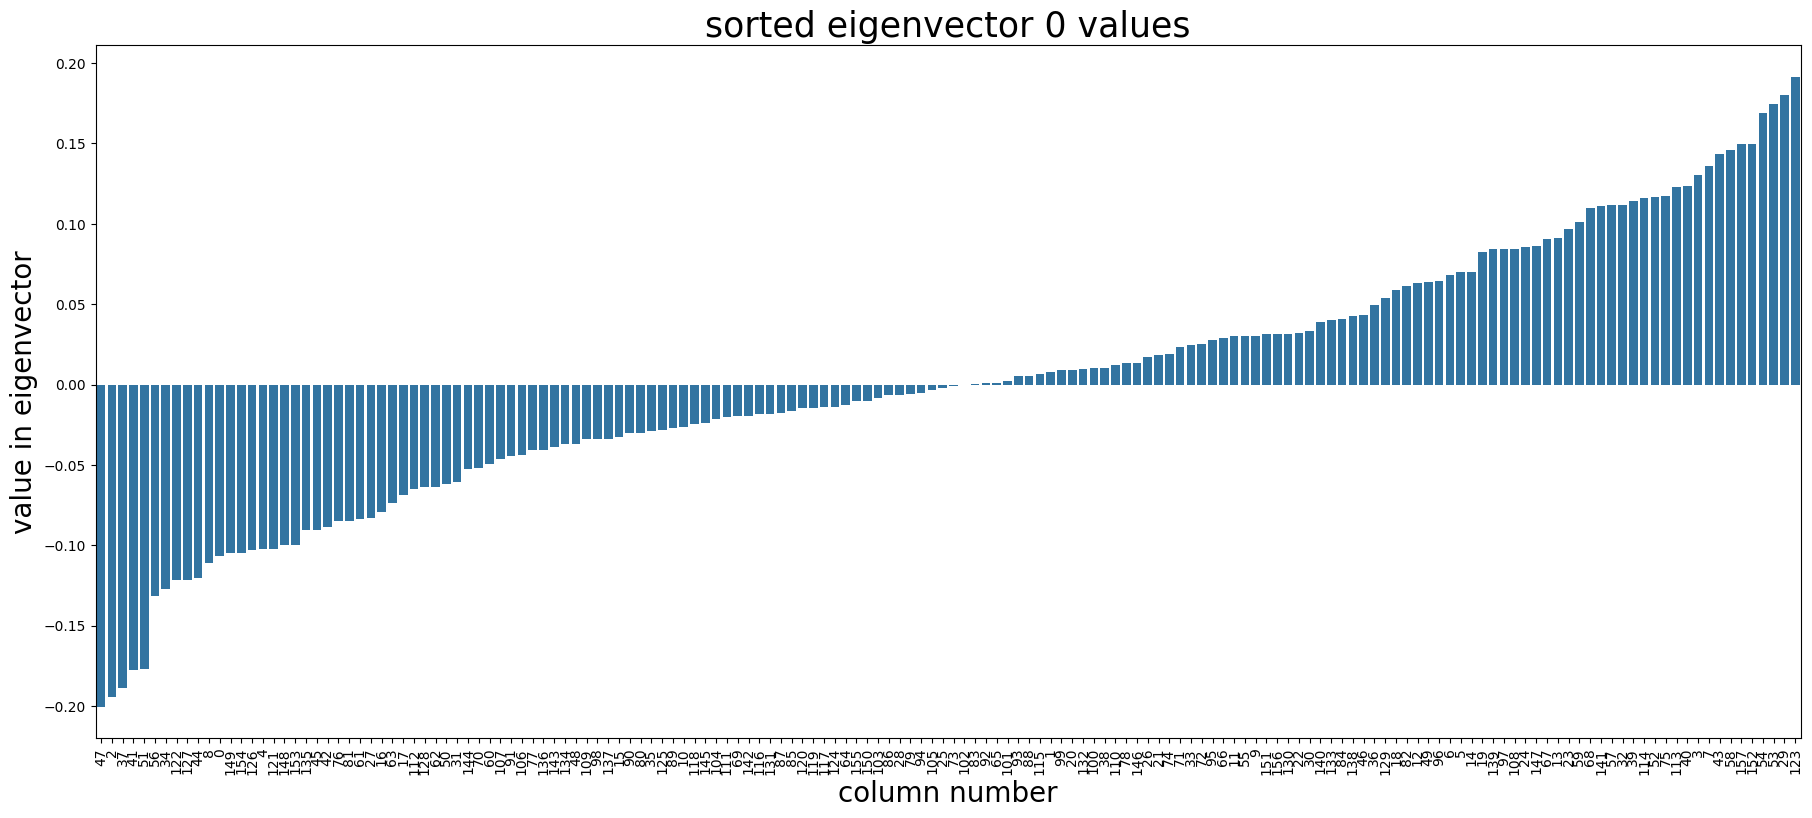

In [26]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
df_component_0 = df_pca_components[["column_name", 0]].sort_values(by=0)

display(df_component_0.head(15))
display(df_component_0.tail(15))

ax = plot_single_pca_component_bargraph(df_component_0)

fig = plt.gcf()
output_file_path = os.path.join("output", "sorted-component-0.png")
fig.savefig(output_file_path, dpi=300)

,column_name,1
3,FINANZ_SPARER,-0.212145
13,SEMIO_REL,-0.211845
6,FINANZ_UNAUFFAELLIGER,-0.207415
23,SEMIO_PFLICHT,-0.203833
24,SEMIO_TRADV,-0.200817
147,decade_5,-0.195196
5,FINANZ_ANLEGER,-0.192725
48,ONLINE_AFFINITAET,-0.162062
19,SEMIO_RAT,-0.161098
18,SEMIO_KULT,-0.160282


,column_name,1
20,SEMIO_KRIT,0.081184
53,PLZ8_ANTG3,0.083043
79,FINANZTYP_5,0.091825
7,FINANZ_HAUSBAUER,0.094461
70,CJT_GESAMTTYP_2.0,0.097927
143,decade_1,0.099895
113,LP_STATUS_FEIN_1.0,0.108313
144,decade_2,0.110626
30,W_KEIT_KIND_HH,0.126457
16,SEMIO_LUST,0.153583


/mnt/c/Users/mattp/OneDrive/Documents/Training/Udacity - Introduction to Machine Learning with TensorFlow/03 Unsupervised Learning/06 Project - Identify Customer Segments/udacity-project-creating-customer-segments/plotting.py:203: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_single_component.index.tolist())


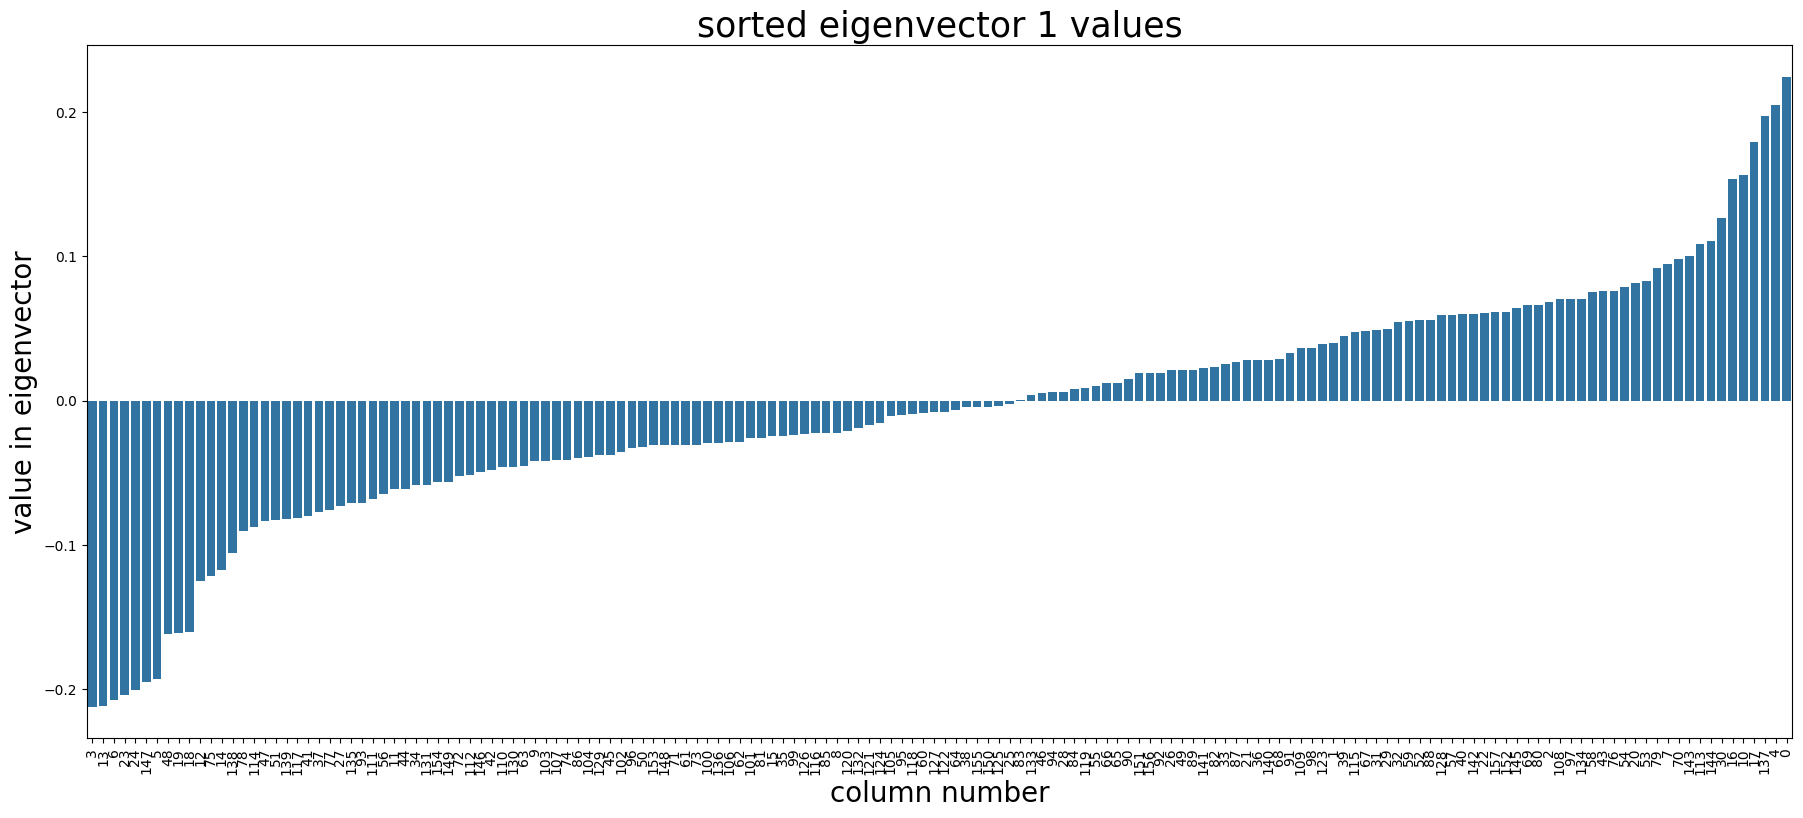

In [27]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
df_component_1 = df_pca_components[["column_name", 1]].sort_values(by=1)

display(df_component_1.head(15))
display(df_component_1.tail(15))

ax = plot_single_pca_component_bargraph(df_component_1)

fig = plt.gcf()
output_file_path = os.path.join("output", "sorted-component-1.png")
fig.savefig(output_file_path, dpi=300)

,column_name,2
1,ANREDE_KZ,-0.339949
22,SEMIO_KAEM,-0.310830
21,SEMIO_DOM,-0.277835
20,SEMIO_KRIT,-0.259810
17,SEMIO_ERL,-0.200991
5,FINANZ_ANLEGER,-0.153454
19,SEMIO_RAT,-0.153346
133,SHOPPER_TYP_2,-0.106713
75,FINANZTYP_1,-0.095905
141,avantgarde,-0.083781


,column_name,2
58,ORTSGR_KLS9,0.068286
30,W_KEIT_KIND_HH,0.068914
43,EWDICHTE,0.069595
10,RETOURTYP_BK_S,0.082073
14,SEMIO_MAT,0.082184
8,GREEN_AVANTGARDE,0.083781
13,SEMIO_REL,0.119695
135,ZABEOTYP_1,0.120058
131,SHOPPER_TYP_0,0.125749
2,FINANZ_MINIMALIST,0.128090


/mnt/c/Users/mattp/OneDrive/Documents/Training/Udacity - Introduction to Machine Learning with TensorFlow/03 Unsupervised Learning/06 Project - Identify Customer Segments/udacity-project-creating-customer-segments/plotting.py:203: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_single_component.index.tolist())


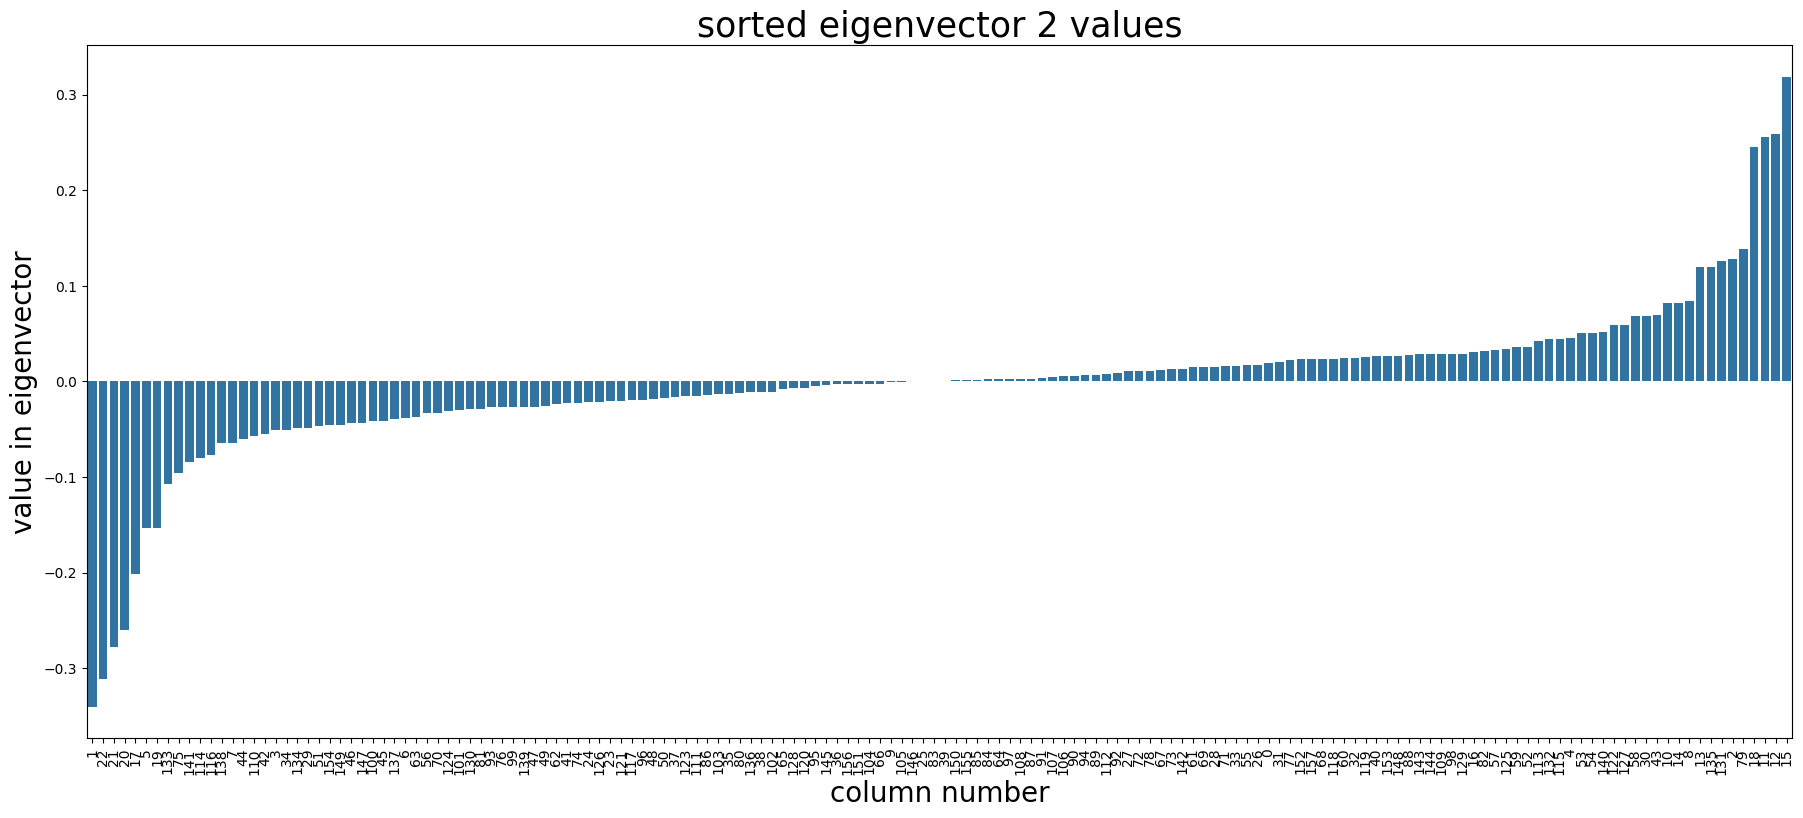

In [28]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
df_component_2 = df_pca_components[["column_name", 2]].sort_values(by=2)

display(df_component_2.head(15))
display(df_component_2.tail(15))

ax = plot_single_pca_component_bargraph(df_component_2)

fig = plt.gcf()
output_file_path = os.path.join("output", "sorted-component-2.png")
fig.savefig(output_file_path, dpi=300)

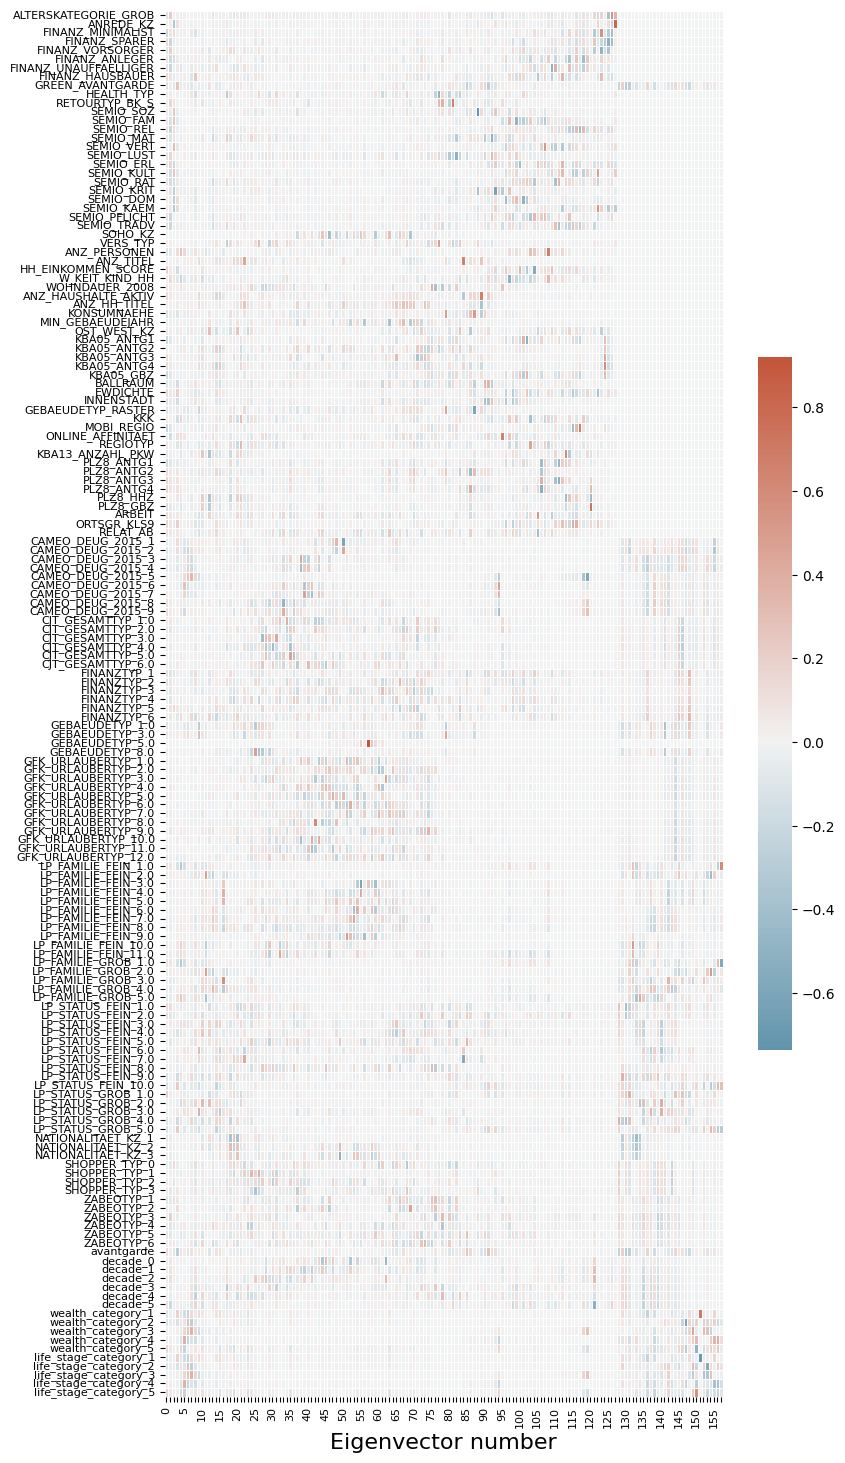

In [29]:
# Generate a heatmap to visualize all eigenvectors
importlib.reload(plotting)
from plotting import plot_pca_components_heatmap
plot_pca_components_heatmap(df_pca_components)

# save to file
output_file_path = os.path.join("output", "eigenvector-heatmap.png")
fig = plt.gcf()
fig.savefig(output_file_path, dpi=300)

### Discussion 2.3: Interpret Principal Components

The principal components (eigenvectors) can be interpretted by examing the values for each feature, with the most positive and most negative features contributing the most.  A row of data is projected onto this principal component via a dot product between the row and the component (i.e. the eigenvector).  This means that large values on the component come from large eigenvector values multiplied by large row values and large negative eigenvector values multiplied by small row values.  And vice-versa for large negative values on the component.

Below, I have provided a high-level qualitative interpretation of the top three eigenvectors.

#### Component 0: "low income vs high income"

At a high level, the first component separates poorer households in areas dominated by multi-family homes (large principal component values) from wealthier households in areas dominated by 1-2 family homes (smaller principal component values).

**Largest positive eigenvector values**
- LP_STATUS_GROB_1.0: Social status - low-income earners (1 = yes, 0 = no)
- HH_EINKOMMEN_SCORE: Estimated household net income (1 = highest income, 6 = very low income)
- PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region
- PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region (0 = none, 2 = high share)

**Largest negative eigenvector values**
- *MOBI_REGIO*: Movement patterns (1 = very high movement, 6 = none)
- *FINANZ_MINIMALIST*: Financial typology - "low financial interest" (1 = very high, 5 = very low)
- *KBA05_ANTG1*: Number of 1-2 family houses in the microcell (0 = none, 4 = very high share of 1-2 family homes)

**Interpretation of large principal component value**
- low-income earners
- high share of 6-10 and 10+ family houses in the PLZ8 region
- very high movement
- very strongly identified as "low financial interest"
- no 1-2 family houses in microcell

**Interpretation of small principal component value**
- high-income earners
- few 6-10 and 10+ family houses in the PLZ8 region
- no movement
- not identified as "low financial interest"
- many 1-2 family houses in microcell

**Visualization of all eigenvalues for this eigenvector**

<img src="output/sorted-component-0.png" width=1500/>

**Table show top positive and negative eigenvector features**

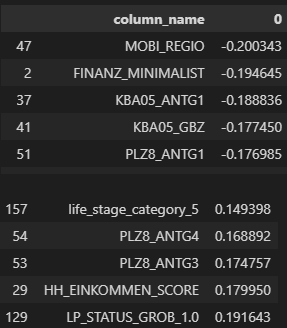

#### Component 1: "older money saver vs younger 'be prepared' financial mindset"

At a high level, the second component seems to separate older more religious and traditionally-minded people from those who are younger and do not as strongly identify as religious or traditionally-minded.

**Largest positive eigenvector values**
- ALTERSKATEGORIE_GROB: Estimated age based on given name analysis (1 = less than 30yo, 4 = greater than 60yo)
- FINANZ_VORSORGER: financial typology - "be prepared" (1 = very high, 5 = very low)
- ZABEOTYP_3: energy consumption typology category (0 if NOT fair supplied, 1 if fair supplied)

**Largest negative eigenvector values**
- FINANZ_SPARER: financial typology - "money-saver" (1 = very high, 5 = very low)
- SEMIO_REL: Personality typology for religious (1 = highest affinity, 7 = lowest affinity)
- FINANZ_UNAUFFAELLIGER: financial typology - "inconspicuous" (1 = very high, 5 = very low)
- SEMIO_PFLICHT: Personality typology for "dutiful" (1 = highest affinity, 7 = lowest affinity)
- SEMIO_TRADV: Personality typology for "traditional-minded" (1 = highest affinity, 7 = lowest affinity)

**Interpretation of large principal component value**
- energy consumption typology of "fair supplied"
- very **low** financial typology of "be prepared"
- estimate age is older
- very high financial typology of "money-saver" and "inconspicuous"
- personality typology that highly identifies as religious, dutiful, and tranditional-minded

**Interpretation of small principal component value**
- energy consumption typology NOT of "fair supplied"
- very **high** financial typology of "be prepared"
- estimate age is younger
- very low financial typology of "money-saver" and "inconspicuous"
- personality typology that does not identify as religious, dutiful, and tranditional-minded

**Visualization of all eigenvalues for this eigenvector**

<img src="output/sorted-component-1.png" width=1500/>


**Table show top positive and negative eigenvector features**

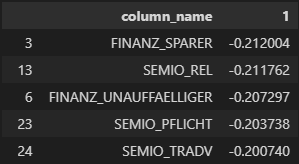

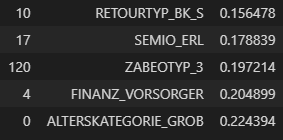

#### Component 2: "critical-minded investors vs family-oriented non-investors"

At a high level, this component separates investors that strongly identify as family-, socially-, and culturally-minded (small principal component value) from non-investors that strongly identify as combative, dominant-minded, and critical-minded (large principal component value).


**Largest positive eigenvector values**

- SEMIO_VERT: dreamful (1 = highest affinity, 7 = lowest affinity)
- SEMIO_FAM: family-minded (1 = highest affinity, 7 = lowest affinity)
- SEMIO_SOZ: socially-minded (1 = highest affinity, 7 = lowest affinity)
- SEMIO_KULT: cultural-minded (1 = highest affinity, 7 = lowest affinity)
- FINANZTYP_5: "investor" is the most descriptive financial type for individual

**Largest negative eigenvector values**
- ANREDE_KZ: gender (1 = male, 2 = female)
- SEMIO_KAEM: combative attitude (1 = highest affinity, 7 = lowest affinity)
- SEMIO_DOM: dominant-minded (1 = highest affinity, 7 = lowest affinity)
- SEMIO_KRIT: critical-minded (1 = highest affinity, 7 = lowest affinity)
- SEMIO_ERL: event-oriented (1 = highest affinity, 7 = lowest affinity)
- FINANZ_ANLEGER: financial typology - "investor" (1 = very high, 5 = very low)

**Interpretation of large principal component value**
- people that identify strongly as NOT dreamful, family-minded, socially-minded, cultural-minded
- people that identify strongly as combative attitude, dominant-minded, critical-minded, event-oriented
- are male
- are investors

**Interpretation of small principal component value**
- people that identify strongly as dreamful, family-minded, socially-minded, cultural-minded
- people that identify strongly as NOT combative attitude, dominant-minded, critical-minded, event-oriented
- are female
- are NOT investors

**Visualization of all eigenvalues for this eigenvector**

<img src="output/sorted-component-2.png" width=1500/>

**Table show top positive and negative eigenvector features**

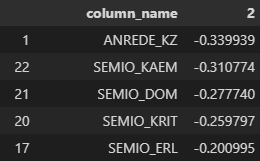

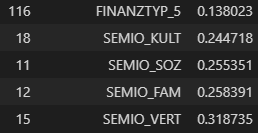

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
#from sklearn.cluster import KMeans
data_kmeans = []
for n_clusters in range(5, 150, 5):
    model = KMeans(n_clusters=n_clusters).fit(data_pca)
    score = -1.0 * model.score(data_pca)
    data_kmeans.append([n_clusters, score])

df_kmeans = pd.DataFrame(data_kmeans, columns=["n_clusters", "score"])
display(df_kmeans)

In [ ]:
# plot df_kmeans to visually identify the number of clusters with which to proceed
n_clusters = 50

fig, ax = plt.subplots()
ax.plot(df_kmeans["n_clusters"], df_kmeans["score"], marker="o", linestyle="dashed")
ax.set_xlabel("num clusters", fontsize=16)
ax.set_ylabel("score (SSE)", fontsize=16)

# plot vertical line showing cluster count I have chosen
ax.plot([n_clusters, n_clusters], [df_kmeans["score"].min(), df_kmeans["score"].max()], "--")

output_file_path = os.path.join("output", "kmeans-n_clusters-vs-SSE.png")
fig.savefig(output_file_path, dpi=300)

In [30]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters).fit(data_pca)
cluster_labels_demographics = kmeans.predict(data_pca)
score = -1.0 * kmeans.score(data_pca)

print(f"score (SSE) for {n_clusters} clusters: {score:.3e}")

score (SSE) for 50 clusters: 6.363e+07


### Discussion 3.1: Apply Clustering to General Population

To determine the number of clusters to use in the downstream analysis, I have calculated the SSE (squared sum Euclidean distance) after running k-means clustering for k=5 to k=150.  The smaller the SSE, the tighter each of the clusters are, but as k increases, you encounter a point of diminishing marginal returns of adding another cluster.  Based on the "elbow" of the plot (where it visually begins to level off), I have decided to proceed with k=50 for the remainder of this analysis.  This should be enough clusters to distinguish different customer groups and it does not seem likely for there to be significant benefit to retaining a greater number of clusters.

<img src="output/kmeans-n_clusters-vs-SSE.png" width=800>


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [31]:
importlib.reload(utils)
#from utils import transform_features

# Load in the customer demographics data.
df_customers = pd.read_csv("data/Udacity_CUSTOMERS_Subset.csv", delimiter=";")
df_feature_summary = pd.read_csv("data/AZDIAS_Feature_Summary.csv", delimiter=";")

# clean data
df_customers_cleaned = clean_data(df_customers, df_feature_summary)

# transform the data
#df_customers_nans_removed, data_customers_scaled = transform_features(df_customers_cleaned)
data_customers_scaled = scaler.transform(df_customers_cleaned)

# project onto the principal components
data_customers_pca = pca.transform(data_customers_scaled)

# assign cluster identification
cluster_labels_customers = kmeans.predict(data_customers_pca)

Quick checks to verify things worked as expected

In [32]:
# We expect the columns to be identical between the customer data and the general population data
columns_customers = df_customers_cleaned.columns.tolist()
columns_demographics = df_cleaned.columns.tolist()
print(f"columns match between customers and general population: {columns_customers == columns_demographics}")

columns match between customers and general population: True


In [33]:
# Check that we didn't accidentally modify scaler, pca, or kmeans objects
temp_scaled = scaler.transform(df_cleaned)
temp_pca = pca.transform(temp_scaled)
temp_cluster_labels_demographics = kmeans.predict(temp_pca)

labels_match = (temp_cluster_labels_demographics == cluster_labels_demographics).all()
print(f"cluster labels unchanged for general population: {labels_match}")

del temp_scaled
del temp_pca
del temp_cluster_labels_demographics
gc.collect();

cluster labels unchanged for general population: True


34121

In [34]:
# check that scaling and then unscaling data gives back the original data
temp_scaled = scaler.transform(df_cleaned)
temp_unscaled = scaler.inverse_transform(temp_scaled)

all_close = np.allclose(temp_unscaled, df_cleaned.iloc[:][:].to_numpy(dtype="float64"))
print(f"performing a scaling transormation and then inverse_transformation matches original data: {all_close}")

del temp_scaled
del temp_unscaled
gc.collect();

performing a scaling transormation and then inverse_transformation matches original data: True


0

In [39]:
# check that project onto PCA components and then back to the original space give the same original data
temp_scaled = pca.inverse_transform(data_pca)
all_close = np.allclose(temp_scaled, data_scaled)
print(f"performing a pca projection and then inverse pca projection matches original data: {all_close}")

del temp_scaled
gc.collect();

performing a pca projection and then inverse pca projection matches original data: True


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [111]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
importlib.reload(utils)
from utils import get_cluster_counts_comparison_df

groups = ["demographics", "customer"]
normalization_basis_group = "demographics"
df_cluster_comparison_wide, df_cluster_comparison_long \
        = get_cluster_counts_comparison_df(cluster_labels_demographics, cluster_labels_customers, groups, normalization_basis_group)

print(f"df_cluster_comparison_wide.shape: {df_cluster_comparison_wide.shape}")
print(f"df_cluster_comparison_long.shape: {df_cluster_comparison_long.shape}")

display(df_cluster_comparison_wide.head(10))
display(df_cluster_comparison_long.head(10))
display(df_cluster_comparison_long.tail(10))

50
50
df_cluster_comparison_wide.shape: (50, 12)
df_cluster_comparison_long.shape: (100, 8)


count              count_error                   frac  \
group      customer demographics    customer demographics  customer   
cluster_id                                                            
0              3749         9547   61.229078    97.708751  0.032419   
1               143        12528   11.958261   111.928549  0.001237   
2              3025        14870   55.000000   121.942609  0.026158   
3              1239         9669   35.199432    98.331073  0.010714   
4              5430        21493   73.688534   146.604911  0.046955   
5               577        14048   24.020824   118.524259  0.004989   
6              2683        20006   51.797683   141.442568  0.023201   
7               745        22989   27.294688   151.621239  0.006442   
8              2063        13850   45.420260   117.686023  0.017839   
9              2407        16094   49.061186   126.862130  0.020814   

                        frac_error              normalized_frac               \
group      demographics   customer demographics        customer demographics   
cluster_id                                                                     
0              0.015319   0.000529     0.000157        2.116230          1.0   
1              0.020102   0.000103     0.000180        0.061513          1.0   
2              0.023860   0.000476     0.000196        1.096298          1.0   
3              0.015515   0.000304     0.000158        0.690564          1.0   
4              0.034488   0.000637     0.000235        1.361498          1.0   
5              0.022541   0.000208     0.000190        0.221348          1.0   
6              0.032102   0.000448     0.000227        0.722728          1.0   
7              0.036888   0.000236     0.000243        0.174643          1.0   
8              0.022224   0.000393     0.000189        0.802720          1.0   
9              0.025824   0.000424     0.000204        0.805984          1.0   

           normalized_frac_error               
group                   customer demographics  
cluster_id                                     
0                       0.040788     0.014474  
1                       0.005173     0.012635  
2                       0.021866     0.011597  
3                       0.020838     0.014382  
4                       0.020679     0.009646  
5                       0.009402     0.011932  
6                       0.014859     0.009999  
7                       0.006501     0.009327  
8                       0.018944     0.012017  
9                       0.017614     0.011148

,cluster_id,count,count_error,frac,frac_error,group,normalized_frac,normalized_frac_error
0,0,9547,97.708751,0.015319,0.000157,demographics,1.0,0.014474
1,1,12528,111.928549,0.020102,0.000180,demographics,1.0,0.012635
2,2,14870,121.942609,0.023860,0.000196,demographics,1.0,0.011597
3,3,9669,98.331073,0.015515,0.000158,demographics,1.0,0.014382
4,4,21493,146.604911,0.034488,0.000235,demographics,1.0,0.009646
5,5,14048,118.524259,0.022541,0.000190,demographics,1.0,0.011932
6,6,20006,141.442568,0.032102,0.000227,demographics,1.0,0.009999
7,7,22989,151.621239,0.036888,0.000243,demographics,1.0,0.009327
8,8,13850,117.686023,0.022224,0.000189,demographics,1.0,0.012017
9,9,16094,126.862130,0.025824,0.000204,demographics,1.0,0.011148


,cluster_id,count,count_error,frac,frac_error,group,normalized_frac,normalized_frac_error
90,40,2386,48.846699,0.020632,0.000422,customer,1.446057,0.033340
91,41,867,29.444864,0.007497,0.000255,customer,0.556893,0.019866
92,42,213,14.594520,0.001842,0.000126,customer,0.168088,0.011695
93,43,107,10.344080,0.000925,0.000089,customer,0.161160,0.015811
94,44,4295,65.536250,0.037140,0.000567,customer,2.178250,0.039386
95,45,4173,64.598762,0.036085,0.000559,customer,1.526722,0.026773
96,46,254,15.937377,0.002196,0.000138,customer,0.078470,0.004959
97,47,242,15.556349,0.002093,0.000135,customer,0.084025,0.005443
98,48,2717,52.124850,0.023495,0.000451,customer,0.927186,0.019257
99,49,176,13.266499,0.001522,0.000115,customer,0.070226,0.005328


In [41]:
# quick check on first row to demonstrate that the numbers make sense

# TODO: needs to be update for proper error propogation

# demographics numbers
count = 6677
count_error = np.sqrt(count)
total_count = len(cluster_labels_demographics)
frac = count / total_count
basis_frac = frac
frac_error = count_error / total_count
normalized_frac = frac / frac
#normalized_frac_error = frac_error / frac
print("Demographics")
print(f"\tcount:                 {count}")
print(f"\tcount_error:           {count_error}")
print(f"\tfrac:                  {frac}")
print(f"\tfrac_error:            {frac_error}")
print(f"\tnormalized_frac:       {normalized_frac}")
#print(f"\tnormalized_frac_error: {normalized_frac_error}")

# customers numbers
count = 75
count_error = np.sqrt(count)
total_count = len(cluster_labels_customers)
frac = count / total_count
frac_error = count_error / total_count
normalized_frac = frac / basis_frac
#normalized_frac_error = frac_error / basis_frac
print("Customers")
print(f"\tcount:                 {count}")
print(f"\tcount_error:           {count_error}")
print(f"\tfrac:                  {frac}")
print(f"\tfrac_error:            {frac_error}")
print(f"\tnormalized_frac:       {normalized_frac}")
#print(f"\tnormalized_frac_error: {normalized_frac_error}")

Demographics
	count:                 6677
	count_error:           81.7129120763665
	frac:                  0.0107139017568745
	frac_error:            0.00013111638643916647
	normalized_frac:       1.0
Customers
	count:                 75
	count_error:           8.660254037844387
	frac:                  0.0006485476855494928
	frac_error:            7.488783616686169e-05
	normalized_frac:       0.06053328659032707


Text(0.5, 1.0, 'customers vs general population')

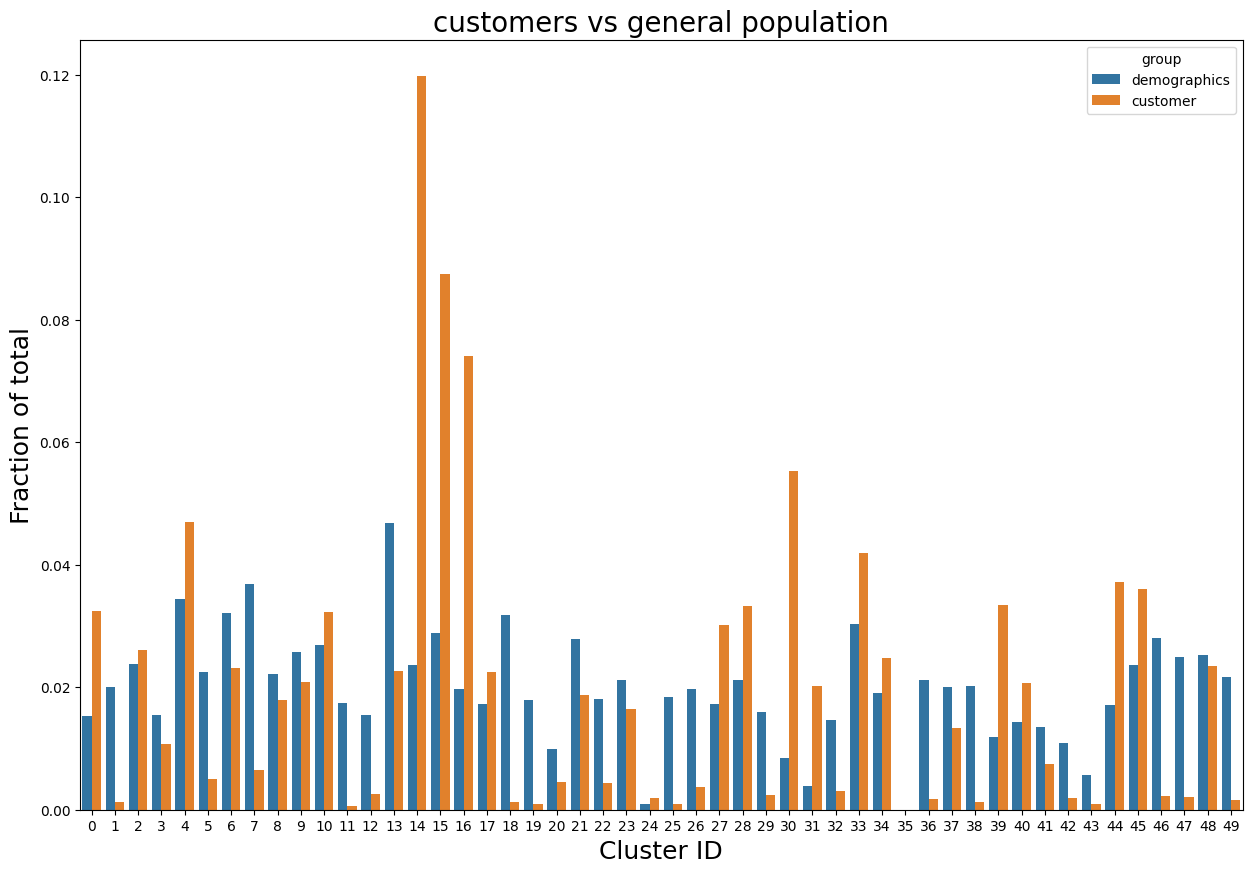

In [112]:
# plot customer frac and general population frac for each cluster
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.barplot(df_cluster_comparison_long, x="cluster_id", y="frac", hue="group", ax=ax)
ax.set_xlabel("Cluster ID", fontsize=18)
ax.set_ylabel("Fraction of total", fontsize=18)
ax.set_title("customers vs general population", fontsize=20)

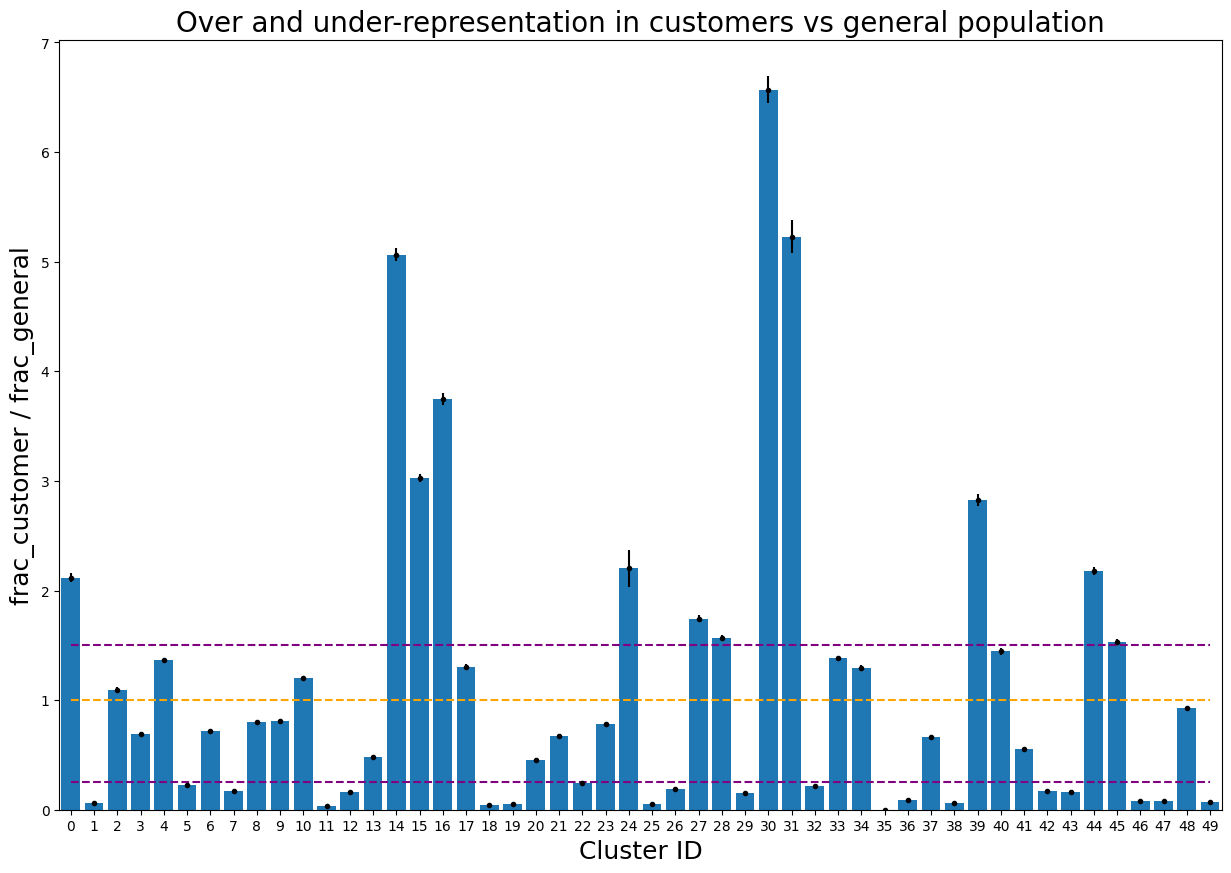

In [300]:
fig, ax = plt.subplots(figsize=(15, 10))
customer_idx = df_cluster_comparison_long["group"] == "customer"

# plot lines showing equality (y = 1.0) and for signicantly over-represented (y >= 1.5)
# and for significantly under-represented (y <= 0.5)
ax.plot([0, n_clusters-1], [1.0, 1.0], "--", color="orange")
ax.plot([0, n_clusters-1], [0.25, 0.25], "--", color="purple")
ax.plot([0, n_clusters-1], [1.5, 1.5], "--", color="purple")

x = df_cluster_comparison_long[customer_idx]["cluster_id"]
y = df_cluster_comparison_long[customer_idx]["normalized_frac"]
yerr = df_cluster_comparison_long[customer_idx]["normalized_frac_error"]
ax.bar(x, y)
ax.errorbar(x, y, yerr=yerr, fmt=".", color="black")
ax.set_xlim([-0.5, n_clusters-0.5])
ax.set_xticks(range(n_clusters))

ax.set_xlabel("Cluster ID", fontsize=18)
ax.set_ylabel("frac_customer / frac_general", fontsize=18)
ax.set_title("Over and under-representation in customers vs general population", fontsize=20)

output_file_path = os.path.join("output", "cluster_over_and_under_representation.png")
fig.savefig(output_file_path, dpi=300)

In [248]:
# get over- and under- represented cluster ids
idx = (df_cluster_comparison_long["group"] == "customer") & (df_cluster_comparison_long["normalized_frac"] <= 0.25)
underrepresented_cluster_ids_arr = df_cluster_comparison_long[idx]["cluster_id"].to_numpy()
idx = (df_cluster_comparison_long["group"] == "customer") & (df_cluster_comparison_long["normalized_frac"] >= 1.5)
overrepresented_cluster_ids_arr = df_cluster_comparison_long[idx]["cluster_id"].to_numpy()

print(f"underrepresented cluster ids: {underrepresented_cluster_ids_arr}")
print(f"overrepresented cluster ids: {overrepresented_cluster_ids_arr}")

underrepresented cluster ids: [ 1  5  7 11 12 18 19 22 25 26 29 32 35 36 38 42 43 46 47 49]
overrepresented cluster ids: [ 0 14 15 16 24 27 28 30 31 39 44 45]


In [249]:
importlib.reload(utils)
from utils import get_centroids, get_centroids_df

# load centroids in PCA, scaled, and unscaled coordinates
centroids_pca, centroids_scaled, centroids_unscaled = get_centroids(kmeans, pca, scaler)
df_centroids_pca, df_centroids_scaled, df_centroids_unscaled = get_centroids_df(kmeans, pca, scaler, df_cluster_comparison_long)

# if a cluster is too small <0.01% of total demographics, exclude from analysis
cluster_ids_to_ignore = df_centroids_pca[(df_centroids_pca["demographics_frac"] <0.0001)]["cluster_id"].tolist()
print(f"cluster_ids to drop: {cluster_ids_to_ignore}")

# Drop tiny clusters
df_centroids_pca.drop(labels=cluster_ids_to_ignore, axis=0, inplace=True)
df_centroids_scaled.drop(labels=cluster_ids_to_ignore, axis=0, inplace=True)
df_centroids_unscaled.drop(labels=cluster_ids_to_ignore, axis=0, inplace=True)

# Display
display(df_centroids_pca.head(5))
display(df_centroids_pca.tail(5))

cluster_ids to drop: [35]


,cluster_id,normalized_customer_frac,demographics_frac,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50,pca_51,pca_52,pca_53,pca_54,pca_55,pca_56,pca_57,pca_58,pca_59,pca_60,pca_61,pca_62,pca_63,pca_64,pca_65,pca_66,pca_67,pca_68,pca_69,pca_70,pca_71,pca_72,pca_73,pca_74,pca_75,pca_76,pca_77,pca_78,pca_79,pca_80,pca_81,pca_82,pca_83,pca_84,pca_85,pca_86,pca_87,pca_88,pca_89,pca_90,pca_91,pca_92,pca_93,pca_94,pca_95,pca_96,pca_97,pca_98,pca_99,pca_100,pca_101,pca_102,pca_103,pca_104,pca_105,pca_106,pca_107,pca_108,pca_109,pca_110,pca_111,pca_112,pca_113,pca_114,pca_115,pca_116,pca_117,pca_118,pca_119,pca_120,pca_121,pca_122,pca_123,pca_124,pca_125,pca_126,pca_127,pca_128,pca_129,pca_130,pca_131,pca_132,pca_133,pca_134,pca_135,pca_136,pca_137,pca_138,pca_139,pca_140,pca_141,pca_142,pca_143,pca_144,pca_145,pca_146,pca_147,pca_148,pca_149,pca_150,pca_151,pca_152,pca_153,pca_154,pca_155,pca_156,pca_157
11,11,0.030718,0.017453,6.068471,-3.459689,2.673229,-0.653236,0.904782,-1.365179,-0.580033,-0.584889,2.139860,-0.248506,-0.922346,0.121558,0.098279,0.736053,-0.077101,-0.691963,0.053197,-0.141489,0.166995,0.038823,0.773014,0.333430,-0.491918,-0.178209,-0.921993,0.173996,0.903534,-0.510287,-0.037168,0.298636,-0.051005,-0.240566,0.257227,0.140981,0.156289,-0.379471,-0.330401,-0.258823,0.112046,-0.168888,0.209312,0.013370,-0.005069,-0.025676,0.199933,0.143579,-0.197260,-0.003260,0.110545,0.177948,0.037475,-0.114951,0.070900,0.100686,-0.036680,0.158697,0.003811,-0.015036,0.040755,-0.123502,0.007412,-0.196553,-0.122425,-0.213744,0.024192,0.092085,-0.239500,-0.076299,-0.253081,0.032258,-0.037324,-0.034540,0.424800,0.235271,-0.033271,0.162369,-0.014159,0.065206,0.306685,0.014876,0.293989,-0.023003,0.142122,-0.298805,0.035075,0.014144,0.154442,-0.010179,-0.061008,-0.024154,-0.016243,-0.026236,-0.082327,-0.001093,0.031113,0.114785,0.156560,0.027673,-0.138558,-0.199184,-0.016178,0.112594,-0.000672,-0.142660,0.132992,0.028597,0.061336,0.097190,0.038001,-0.125944,-0.052300,-0.009727,-0.061073,-0.015377,-0.105483,0.001629,0.134422,-0.045664,-0.011639,-0.034005,0.005657,-0.104586,0.038587,-0.080581,0.018027,0.107883,-0.047728,-0.030357,-1.534951e-16,-1.698346e-15,-8.005171e-16,7.918829e-16,-1.560037e-16,9.020560e-17,5.567990e-17,-5.474909e-16,1.107056e-16,-3.946523e-16,-1.534939e-16,-3.941974e-16,9.895126e-17,-1.691931e-16,3.916449e-16,-3.053133e-16,-1.553152e-16,3.742048e-16,-2.661888e-16,3.537399e-16,1.127392e-16,-1.260035e-16,5.281025e-16,-3.260936e-17,-2.403933e-16,-3.415649e-17,8.480946e-17,-1.566693e-16,-1.200905e-16,1.556914e-16
18,18,0.039519,0.031728,5.668920,-2.350512,-2.716921,0.632479,0.318050,-1.672719,-0.386901,-0.300717,1.134337,-0.663854,-0.609042,-0.168725,-0.303247,-0.783327,0.452374,-1.041587,-0.020616,0.691972,-0.211358,0.089420,0.287133,-0.073936,-0.466166,0.353490,-0.596635,0.311681,0.132996,-0.029318,0.006775,0.142905,-0.175884,-0.062043,0.256754,0.141847,0.146830,-0.157114,-0.416860,-0.129007,-0.094143,-0.289375,0.157507,-0.180337,-0.085590,0.071470,-0.092768,-0.028757,-0.041879,0.096701,-0.096281,-0.038908,0.024932,-0.129083,0.037682,0.126037,-0.047069,-0.008076,0.072123,-0.053748,0.196244,0.088501,0.079133,-0.107766,0.014122,-0.122432,0.035976,0.185670,-0.153857,0.044072,0.101396,-0.257974,0.116816,-0.100487,-0.070696,0.088584,0.128234,0.011936,0.041122,0.056982,-0.047159,-0.022419,-0.137590,-0.035197,0.015787,0.019973,-0.020093,0.288217,0.055684,0.041271,-0.021865,-0.002013,0.059376,-0.058399,0.034693,-0.030490,0.101568,-0.004477,-0.150896,0.005933,0.125785,0.093345,-0.023050,-0.011100,0.068875,0.107745,-0.013999,0.038484,-0.004898,-0.035375,-0.064455,0.083749,0.020421,0.011283,-0.008066,0.012681,0.062342,-0.036358,-0.071564,-0.

,cluster_id,normalized_customer_frac,demographics_frac,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50,pca_51,pca_52,pca_53,pca_54,pca_55,pca_56,pca_57,pca_58,pca_59,pca_60,pca_61,pca_62,pca_63,pca_64,pca_65,pca_66,pca_67,pca_68,pca_69,pca_70,pca_71,pca_72,pca_73,pca_74,pca_75,pca_76,pca_77,pca_78,pca_79,pca_80,pca_81,pca_82,pca_83,pca_84,pca_85,pca_86,pca_87,pca_88,pca_89,pca_90,pca_91,pca_92,pca_93,pca_94,pca_95,pca_96,pca_97,pca_98,pca_99,pca_100,pca_101,pca_102,pca_103,pca_104,pca_105,pca_106,pca_107,pca_108,pca_109,pca_110,pca_111,pca_112,pca_113,pca_114,pca_115,pca_116,pca_117,pca_118,pca_119,pca_120,pca_121,pca_122,pca_123,pca_124,pca_125,pca_126,pca_127,pca_128,pca_129,pca_130,pca_131,pca_132,pca_133,pca_134,pca_135,pca_136,pca_137,pca_138,pca_139,pca_140,pca_141,pca_142,pca_143,pca_144,pca_145,pca_146,pca_147,pca_148,pca_149,pca_150,pca_151,pca_152,pca_153,pca_154,pca_155,pca_156,pca_157
15,15,3.025651,0.028897,-5.517325,0.669829,1.072421,3.707837,-1.096120,-2.161546,-2.090762,0.463883,0.482978,-0.114605,0.125587,-0.199576,0.017054,0.077098,-0.826684,0.170550,0.083473,-0.276370,0.703234,-0.153207,-0.347356,-0.033274,-0.491748,-0.507738,-0.120440,0.057530,0.029927,-0.019563,0.022340,0.313805,-0.231492,-0.203321,0.057783,-0.149764,-0.384466,0.051865,-0.182348,0.336288,-0.085771,-0.125829,-0.044320,-0.174364,0.156504,0.067815,-0.387539,-0.127986,0.189329,-0.427168,-0.730434,-0.041873,1.502227,0.172551,0.200516,0.034353,0.232813,-0.022367,0.166406,-0.008348,0.113745,-0.065785,0.118727,-0.293909,-0.083120,0.176513,-0.135140,-0.328753,-0.038304,0.060460,-0.110016,-0.307381,0.153183,0.091856,-0.043290,-0.014665,0.064472,-0.033201,-0.137098,0.117888,-0.065249,0.013146,0.069849,0.008575,-0.147581,0.031123,0.015310,0.064032,-0.000707,0.020523,-0.021050,-0.022691,-0.137184,0.104311,0.021937,0.046548,-0.028442,-0.038294,0.047379,0.019238,-0.006671,-0.000045,0.005105,-0.012992,-0.016809,-0.007510,-0.008448,-0.009254,0.002275,0.012212,0.004932,0.012115,-0.001200,0.004140,-0.013149,-0.013980,-0.003504,0.001712,-0.013760,0.001971,-0.002924,0.008045,-0.003640,0.028307,-0.003057,-0.009168,0.000214,-0.015362,0.004113,0.009884,-3.071504e-16,1.892509e-15,-9.453193e-16,-1.919179e-15,4.299128e-16,-6.517867e-16,4.656240e-17,8.504006e-16,2.110289e-15,-2.330182e-16,3.004671e-16,-2.289018e-16,6.561584e-16,2.894735e-16,8.411220e-17,2.553744e-16,2.973003e-16,-4.428287e-16,2.339319e-16,-7.326638e-16,-2.350058e-16,-1.733144e-16,9.418826e-17,1.289832e-18,-6.469522e-16,-6.007173e-16,-1.737800e-17,7.546917e-16,1.024916e-16,2.183359e-16
16,16,3.746567,0.019785,-4.635405,1.119006,1.271313,3.845739,-1.586295,-1.874781,-1.545189,0.259420,0.428397,0.084853,0.304950,0.014854,0.172951,-0.146337,-0.069453,0.617056,0.264250,-0.243056,0.172011,0.426506,0.281455,-0.542681,0.165422,-0.443578,-0.357112,0.064496,0.157065,-0.047205,-0.282256,0.331501,-0.095390,0.031597,0.064753,0.437126,-0.072548,-0.053137,0.201478,0.371045,-0.135815,-0.140899,0.245635,-0.025124,-0.790922,-0.089551,0.409255,-0.123847,-0.266197,1.039047,1.703214,-0.048950,-2.830519,-0.179635,-0.205850,-0.214316,-0.335684,-0.227967,-0.170600,0.070913,-0.128186,0.196643,-0.039082,0.167776,-0.008914,0.111240,0.370216,0.539396,0.415318,0.177713,-0.001098,-0.511141,0.414571,0.042185,-0.011724,-0.080704,0.094122,-0.123375,-0.135897,0.006564,-0.059710,0.021600,-0.019256,-0.014140,-0.130751,0.054005,0.208284,0.025240,0.063449,0.056109,-0.000242,0.062163,-0.098452,0.084982,-0.002381,-0.011594,-0.030801,0.012560,0.010629,0.020382,-0.025073,0.029197,-0.022707,-0.006017,-0.009863,-0.017478,0.035885,-0.001957,-0.000103,0.013592,0.000402,0.002956,-0.015188,0.003860,-0.001647,-0.012179,-0.011081,-0.018377,-0.014881,0.0108

In [251]:
# Display data used in interpretting PCA components
columns_to_display = ["cluster_id", "normalized_customer_frac", "pca_0", "pca_1", "pca_2"]
idx_over = df_centroids_pca["cluster_id"].isin(overrepresented_cluster_ids_arr)
idx_under = df_centroids_pca["cluster_id"].isin(underrepresented_cluster_ids_arr)

print("Clusters highly underrepresented in customers")
print("Top five")
display(df_centroids_pca.head(5)[columns_to_display])
print("Stats for all")
display(df_centroids_pca[idx_under].describe()[columns_to_display])

print("Clusters highly overrepresented in customers")
print("Top five")
display(df_centroids_pca.tail(5)[columns_to_display])
print("Stats for all")
display(df_centroids_pca[idx_over].describe()[columns_to_display])

Clusters highly underrepresented in customers
Top five


,cluster_id,normalized_customer_frac,pca_0,pca_1,pca_2
11,11,0.030718,6.068471,-3.459689,2.673229
18,18,0.039519,5.668920,-2.350512,-2.716921
19,19,0.051421,1.681944,-3.698924,-3.341173
25,25,0.054468,3.491188,-4.364629,2.492206
1,1,0.061513,6.898383,-1.195541,-1.989207


Stats for all


,cluster_id,normalized_customer_frac,pca_0,pca_1,pca_2
count,19.000000,19.000000,19.000000,19.000000,19.000000
mean,26.736842,0.120925,2.190886,-2.631497,-0.418608
std,15.223673,0.068412,3.010703,2.189336,2.503915
min,1.000000,0.030718,-2.539217,-6.433352,-3.363068
25%,15.000000,0.062412,-0.554298,-4.184067,-2.594214
50%,26.000000,0.085994,1.887983,-2.747204,-1.656111
75%,40.000000,0.171365,4.608101,-1.557356,2.441777
max,49.000000,0.241545,6.898383,2.393386,3.187574


Clusters highly overrepresented in customers
Top five


,cluster_id,normalized_customer_frac,pca_0,pca_1,pca_2
15,15,3.025651,-5.517325,0.669829,1.072421
16,16,3.746567,-4.635405,1.119006,1.271313
14,14,5.065381,-4.289624,0.880832,3.386951
31,31,5.226379,-1.654955,1.176579,1.690091
30,30,6.568194,-2.322476,0.787275,1.590124


Stats for all


,cluster_id,normalized_customer_frac,pca_0,pca_1,pca_2
count,12.000000,12.000000,12.000000,12.000000,12.000000
mean,26.083333,3.149418,-2.871472,1.619566,0.686946
std,13.297015,1.656055,3.068896,1.925875,1.262086
min,0.000000,1.526722,-5.517325,-0.811398,-1.243371
25%,15.750000,2.023006,-4.622322,0.638466,-0.168438
50%,27.500000,2.513921,-4.375520,0.907028,0.609641
75%,33.000000,4.076270,-2.155596,1.616149,1.351016
max,45.000000,6.568194,4.795735,5.400073,3.386951


In [298]:
# Display the unscaled / untransformed data for interpretation

# These columns were the top positive and negative values in principal components 0, 1, 2
columns_to_display = [
        "LP_STATUS_GROB_1.0",
        "HH_EINKOMMEN_SCORE",
        "PLZ8_ANTG3",
        "PLZ8_ANTG4",
        "MOBI_REGIO",
        "FINANZ_MINIMALIST",
        "KBA05_ANTG1",
        "ALTERSKATEGORIE_GROB",
        "FINANZ_VORSORGER",
        "ZABEOTYP_3",
        "FINANZ_SPARER",
        "SEMIO_REL",
        "FINANZ_UNAUFFAELLIGER",
        "SEMIO_PFLICHT",
        "SEMIO_TRADV",
        "SEMIO_VERT",
        "SEMIO_FAM",
        "SEMIO_SOZ",
        "SEMIO_KULT",
        "FINANZTYP_5",
        "ANREDE_KZ",
        "SEMIO_KAEM",
        "SEMIO_DOM",
        "SEMIO_KRIT",
        "SEMIO_ERL",
        "FINANZ_ANLEGER"
]

print("Clusters highly underrepresented in customers")
print("Top five")
display(df_centroids_unscaled.head(5)[columns_to_display])
print("Stats for all")
display(df_centroids_unscaled[idx_over].describe()[columns_to_display])

print("Clusters highly overrepresented in customers")
print("Top five")
display(df_centroids_unscaled.tail(5)[columns_to_display])
print("Stats for all")
display(df_centroids_unscaled[idx_under].describe()[columns_to_display])

Clusters highly underrepresented in customers
Top five


,LP_STATUS_GROB_1.0,HH_EINKOMMEN_SCORE,PLZ8_ANTG3,PLZ8_ANTG4,MOBI_REGIO,FINANZ_MINIMALIST,KBA05_ANTG1,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,ZABEOTYP_3,FINANZ_SPARER,SEMIO_REL,FINANZ_UNAUFFAELLIGER,SEMIO_PFLICHT,SEMIO_TRADV,SEMIO_VERT,SEMIO_FAM,SEMIO_SOZ,SEMIO_KULT,FINANZTYP_5,ANREDE_KZ,SEMIO_KAEM,SEMIO_DOM,SEMIO_KRIT,SEMIO_ERL,FINANZ_ANLEGER
11,0.980601,5.822194,2.473936,1.339892,1.638687,1.195642,0.313689,1.289510,2.303209,0.028684,4.885630,6.654316,3.849131,6.250437,4.880941,6.148203,6.895835,6.895927,6.896847,0.000276,1.000276,2.107383,1.907787,2.174221,1.690999,4.762986
18,0.973547,5.864144,2.402357,1.119873,1.926306,1.059380,0.433362,1.667341,1.903849,0.027566,4.661676,5.494613,3.938243,6.095241,5.959183,2.167872,3.845430,3.054828,4.516109,0.000152,1.993526,6.155430,6.411916,5.421324,4.028324,4.459360
19,0.904405,4.912520,1.284020,0.415730,3.087034,1.210095,1.565543,1.645711,2.144462,0.028357,4.460496,4.953184,4.231229,5.857678,5.869181,2.229624,3.589174,2.744248,3.847780,0.000981,1.967095,5.667648,6.532192,5.605939,3.992063,4.395042
25,0.944846,5.107432,1.866516,0.842119,2.366646,1.296855,0.862159,1.275856,2.375011,0.017426,4.774506,6.677703,4.167552,6.134878,4.907554,6.238913,6.903023,6.907293,6.906160,0.001133,1.000349,1.939793,1.782260,1.918446,1.797682,4.476344
1,0.985473,5.753432,2.588362,1.806354,1.080460,1.057391,0.094349,1.758062,1.788554,0.036398,4.616299,5.271312,3.546695,5.869253,5.768678,2.224218,3.927921,3.674090,4.295738,0.000479,1.973499,6.397190,6.136893,5.453624,4.134419,4.263889


Stats for all


,LP_STATUS_GROB_1.0,HH_EINKOMMEN_SCORE,PLZ8_ANTG3,PLZ8_ANTG4,MOBI_REGIO,FINANZ_MINIMALIST,KBA05_ANTG1,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,ZABEOTYP_3,FINANZ_SPARER,SEMIO_REL,FINANZ_UNAUFFAELLIGER,SEMIO_PFLICHT,SEMIO_TRADV,SEMIO_VERT,SEMIO_FAM,SEMIO_SOZ,SEMIO_KULT,FINANZTYP_5,ANREDE_KZ,SEMIO_KAEM,SEMIO_DOM,SEMIO_KRIT,SEMIO_ERL,FINANZ_ANLEGER
count,1.200000e+01,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,1.281386e-01,3.561659,1.290927,0.520328,3.590226,4.076297,2.193906,3.418369,4.365387,0.507176,1.579765,2.971731,1.837937,3.036548,2.872589,4.559494,3.545115,4.117135,3.526085,0.246553,1.494389,4.121453,4.459539,4.479358,5.217586,1.857958
std,2.469062e-01,1.092032,0.509272,0.406844,1.078251,0.750741,0.913417,0.224039,0.289406,0.181221,0.293524,0.572690,0.253459,0.345101,0.384381,0.733666,0.587695,0.482588,0.802783,0.157480,0.223157,0.798044,0.542896,0.698916,0.681988,0.430791
min,1.554312e-15,2.211894,0.759318,0.161450,1.017762,2.339254,0.319716,3.088503,3.923077,0.287208,1.116372,1.672941,1.306484,2.345658,2.160469,3.212329,2.181365,3.074635,1.766494,0.065997,1.000407,2.335958,3.200217,2.987308,4.066649,1.217931
25%,1.995928e-03,2.725006,0.825930,0.193509,3.363436,3.881428,1.918010,3.324174,4.167942,0.402540,1.418058,2.837450,1.683095,2.867449,2.765031,4.317114,3.369843,3.881480,3.322025,0.091268,1.436203,3.926293,4.363284,4.311178,4.946977,1.523895
50%,2.382973e-02,3.399409,1.208364,0.401246,4.143498,4.339569,2.630732,3.370290,4.332096,0.474679,1.578232,3.123586,1.820891,3.042153,2.953393,4.677517,3.538447,4.069325,3.665977,0.265328,1.485707,4.048569,4.457053,4.485987,5.193981,1.808249
75%,5.523016e-02,3.919761,1.626446,0.715576,4.209127,4.565271,2.764783,3.492583,4.501475,0.543871,1.819390,3.278304,1.995393,3.308286,3.030492,4.746728,3.793662,4.381968,3.926320,0.340588,1.539889,4.299677,4.657487,4.707386,5.329753,2.135819
max,6.753954e-01,5.584369,2.223840,1.426288,4.390638,4.859644,3.027930,3.866031,4.876506,0.855138,2.008271,3.741618,2.236559,3.498759,3.399917,6.289127,4.662481,5.015542,4.977942,0.488455,1.974400,5.755482,5.453835,5.880847,6.712847,2.600217


Clusters highly overrepresented in customers
Top five


,LP_STATUS_GROB_1.0,HH_EINKOMMEN_SCORE,PLZ8_ANTG3,PLZ8_ANTG4,MOBI_REGIO,FINANZ_MINIMALIST,KBA05_ANTG1,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,ZABEOTYP_3,FINANZ_SPARER,SEMIO_REL,FINANZ_UNAUFFAELLIGER,SEMIO_PFLICHT,SEMIO_TRADV,SEMIO_VERT,SEMIO_FAM,SEMIO_SOZ,SEMIO_KULT,FINANZTYP_5,ANREDE_KZ,SEMIO_KAEM,SEMIO_DOM,SEMIO_KRIT,SEMIO_ERL,FINANZ_ANLEGER
15,2.276639e-03,2.211894,0.952302,0.261203,4.390638,4.572047,3.027930,3.440224,4.386529,0.430340,1.504026,2.919651,1.980232,3.054973,2.944639,4.670998,3.327059,4.046754,3.480426,0.221722,1.504192,4.146260,4.638125,4.426231,5.205397,1.735410
16,4.590430e-02,2.369586,1.167315,0.395620,4.180697,4.354745,2.815166,3.400162,4.363017,0.459692,1.520032,2.872668,2.040876,2.984834,3.000568,4.717194,3.384104,4.156204,3.454826,0.347689,1.499351,4.180373,4.715572,4.545742,5.041930,1.539092
14,1.153794e-03,2.682707,1.332632,0.439731,4.050088,4.859644,2.644021,3.589657,4.635808,0.306841,1.300190,3.741618,1.799511,2.919234,3.120266,6.289127,4.662481,5.015542,4.977942,0.485069,1.000407,2.335958,3.200217,2.987308,4.066649,1.217931
31,8.271299e-03,3.361042,1.729529,0.800662,3.130687,3.645575,1.700579,3.088503,3.923077,0.411911,2.008271,3.424731,2.236559,3.498759,3.399917,4.684036,3.991315,4.352771,3.915219,0.308933,1.445823,4.032258,4.618693,4.346981,4.662117,2.043424
30,1.554312e-15,3.165715,1.592085,0.687215,3.441020,3.960046,1.990487,3.125571,4.083143,0.374429,1.822869,3.454528,2.118531,3.434170,3.332192,4.872336,3.978881,4.469559,4.036149,0.329528,1.407344,3.871385,4.477359,4.203767,4.604262,1.881088


Stats for all


,LP_STATUS_GROB_1.0,HH_EINKOMMEN_SCORE,PLZ8_ANTG3,PLZ8_ANTG4,MOBI_REGIO,FINANZ_MINIMALIST,KBA05_ANTG1,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,ZABEOTYP_3,FINANZ_SPARER,SEMIO_REL,FINANZ_UNAUFFAELLIGER,SEMIO_PFLICHT,SEMIO_TRADV,SEMIO_VERT,SEMIO_FAM,SEMIO_SOZ,SEMIO_KULT,FINANZTYP_5,ANREDE_KZ,SEMIO_KAEM,SEMIO_DOM,SEMIO_KRIT,SEMIO_ERL,FINANZ_ANLEGER
count,1.900000e+01,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,1.900000e+01,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,5.527381e-01,5.012901,1.729417,0.796490,2.706201,2.096671,1.263875,1.951913,2.388650,0.101261,3.969870,5.232082,3.542497,5.554370,4.973194,4.094854,4.848819,4.557243,5.098503,2.899746e-02,1.518346,4.184981,4.534474,4.305179,3.572772,3.887319
std,4.360728e-01,0.868047,0.647546,0.501117,1.024261,0.876738,0.929506,0.502911,0.667568,0.175024,0.764295,0.925675,0.798200,0.765251,0.886898,1.707248,1.442635,1.658835,1.289353,5.992779e-02,0.442872,1.664701,1.715880,1.342805,1.106778,0.773071
min,-3.330669e-16,3.050373,0.806729,0.188565,1.080460,1.057391,0.094349,1.275856,1.461087,0.008640,2.473804,3.122295,1.807560,3.724231,3.002064,2.167872,3.158884,2.621765,3.318835,-2.220446e-16,1.000276,1.860595,1.782260,1.914043,1.690999,2.211275
25%,4.764104e-03,4.889493,1.089321,0.323811,1.726937,1.253475,0.372357,1.658824,1.919578,0.021505,3.621771,4.786006,3.196264,5.368216,4.723889,2.382103,3.756570,3.090245,4.070658,3.773693e-04,1.000882,2.646899,3.063666,3.223494,2.490518,3.325800
50%,8.633099e-01,5.107432,1.643171,0.724427,2.911683,2.050831,1.349587,1.793648,2.180268,0.028684,4.164764,5.104792,3.849131,5.866314,4.920030,3.601723,4.060089,3.714925,4.516109,1.953125e-03,1.682446,4.555026,4.957930,5.016714,4.023970,3.927334
75%,9.261272e-01,5.719866,2.405658,1.265276,3.544894,2.448269,1.939774,2.096833,2.642485,0.047405,4.497877,5.800059,4.071758,5.977828,5.767600,6.034000,6.536042,6.484251,6.555554,3.338038e-02,1.974090,5.495025,6.238053,5.434031,4.213827,4.467852
max,9.854725e-01,5.864144,2.588362,1.806354,4.264648,3.980913,2.731452,3.034596,3.757928,0.596882,4.885630,6.677703,4.437839,6.290707,5.993094,6.408991,6.920178,6.916994,6.919141,2.551220e-01,1.997718,6.660989,6.560881,5.605939,5.369305,4.918143


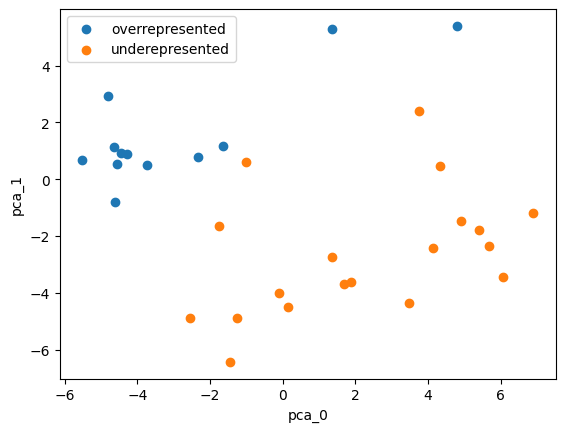

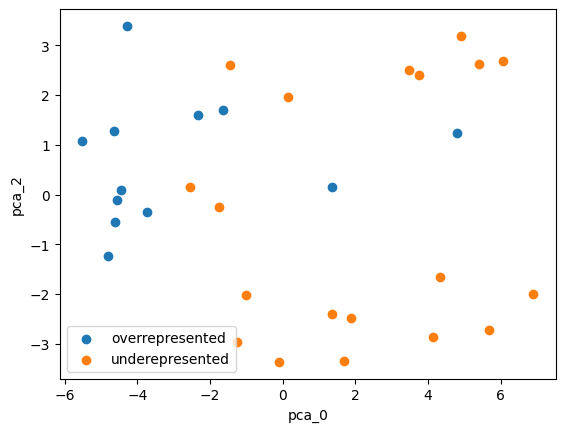

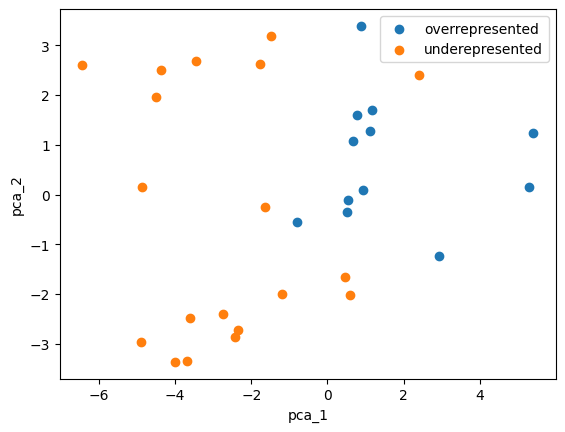

In [205]:
# generate 2D plots for pca_0 vs pca_1, pca_1 vs pca_2, pca_1 vs pca_2
fig, ax = plt.subplots()
x, y = df_centroids_pca[idx_over]["pca_0"], df_centroids_pca[idx_over]["pca_1"]
ax.scatter(x, y, label="overrepresented")
x, y = df_centroids_pca[idx_under]["pca_0"], df_centroids_pca[idx_under]["pca_1"]
ax.scatter(x, y, label="underepresented")
ax.set_xlabel("pca_0")
ax.set_ylabel("pca_1")
ax.legend()
output_file_path = os.path.join("output", "clusters-pca0_vs_pca1.png")
fig.savefig(output_file_path, dpi=300)

fig, ax = plt.subplots()
x, y = df_centroids_pca[idx_over]["pca_0"], df_centroids_pca[idx_over]["pca_2"]
ax.scatter(x, y, label="overrepresented")
x, y = df_centroids_pca[idx_under]["pca_0"], df_centroids_pca[idx_under]["pca_2"]
ax.scatter(x, y, label="underepresented")
ax.set_xlabel("pca_0")
ax.set_ylabel("pca_2")
ax.legend()
output_file_path = os.path.join("output", "clusters-pca0_vs_pca2.png")
fig.savefig(output_file_path, dpi=300)


fig, ax = plt.subplots()
x, y = df_centroids_pca[idx_over]["pca_1"], df_centroids_pca[idx_over]["pca_2"]
ax.scatter(x, y, label="overrepresented")
x, y = df_centroids_pca[idx_under]["pca_1"], df_centroids_pca[idx_under]["pca_2"]
ax.scatter(x, y, label="underepresented")
ax.set_xlabel("pca_1")
ax.set_ylabel("pca_2")
ax.legend()
output_file_path = os.path.join("output", "clusters-pca1_vs_pca2.png")
fig.savefig(output_file_path, dpi=300)


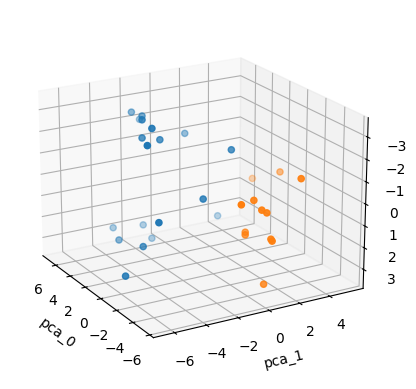

In [297]:
# switch from inline to widget to make 3D plots interactive
%matplotlib inline
#%matplotlib widget

#plt.close()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(-160, 30)
x, y, z = df_centroids_pca[idx_under]["pca_0"], df_centroids_pca[idx_under]["pca_1"], df_centroids_pca[idx_under]["pca_2"]
ax.scatter(x, y, z)
x, y, z = df_centroids_pca[idx_over]["pca_0"], df_centroids_pca[idx_over]["pca_1"], df_centroids_pca[idx_over]["pca_2"]
ax.scatter(x, y, z)
ax.set_xlabel("pca_0")
ax.set_ylabel("pca_1")
ax.set_zlabel("pca_2")

output_file_path = os.path.join("output", "clusters-pca1_vs_pca2_vs_pca3.png")
fig.savefig(output_file_path, dpi=300)

In [228]:
# generate comparison plots for unscaled data between overrepresented and underrepresented clusters and save images to file
# NOTE: df_over and df_under are the raw loaded data so that the plots are easier to interpret.  I find the appropriate rows
#       using the index from df_customers_cleaned and will only plot columns from df_customers_cleaned.
clean_idx = np.in1d(cluster_labels_customers, overrepresented_cluster_ids_arr)
raw_idx = df_customers_cleaned[clean_idx].index.to_numpy()
df_over = df_customers.iloc[raw_idx,:]

clean_idx = np.in1d(cluster_labels_customers, underrepresented_cluster_ids_arr)
raw_idx = df_customers_cleaned[clean_idx].index.to_numpy()
df_under = df_customers.iloc[raw_idx,:]

print(f"df_under.shape: {df_under.shape}")
print(f"df_over.shape: {df_over.shape}")

df_under.shape: (5100, 85)
df_over.shape: (64922, 85)


In [246]:
importlib.reload(utils)
importlib.reload(plotting)
from plotting import plot_comparison_by_histogram, plot_comparison_by_unique_value

columns = list(set(df_customers.columns.tolist()) - {"TITEL_KZ", "AGER_TYP", "KK_KUNDENTYP", "KBA05_BAUMAX", "GEBURTSJAHR", "ALTER_HH"})
columns.sort()

for column in columns:
    fig, ax = plt.subplots()

    num_unique_values = len(set(df_over[column].unique().tolist()) | set(df_under[column].unique().tolist()))
    data_type = "numeric" if df_customers[column].dtype in (int, float) else "non-numeric"

    if data_type == "numeric":
        if num_unique_values > 20:
            ax = plot_comparison_by_histogram(df_over, df_under, column, ax=ax, label1="over", label2="under")
        else:
            ax = plot_comparison_by_unique_value(df_over, df_under, column, ax=ax, label1="over", label2="under")
    else:
        ax = plot_comparison_by_unique_value(df_over, df_under, column, ax=ax, label1="over", label2="under")


    output_file_name = f"comparison-over_and_under_represented-{column}.png"
    output_file_path = os.path.join("output", output_file_name)
    fig.savefig(output_file_path, dpi=300)
    plt.close()

<Axes: >

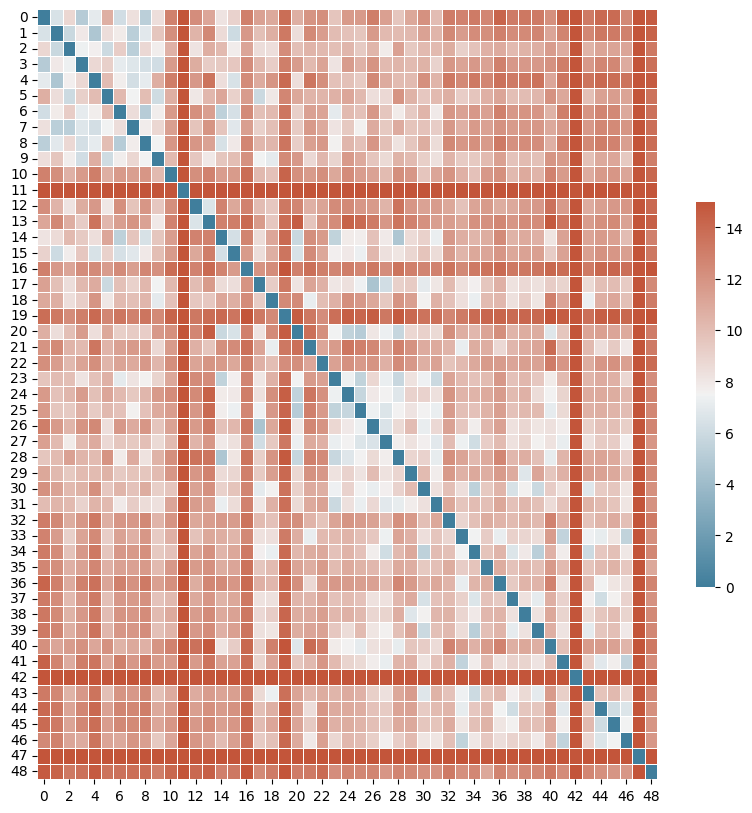

In [162]:
# Plot a heatmap showing the distance between clusters (PCA-space) to see whether over-represented clusters and
# under-represented clusters are closer within group than between groups
from scipy.spatial import distance_matrix

num_clusters, num_columns = df_centroids_pca.shape
num_pca_components = num_columns - 3

cluster_ids = df_centroids_pca["cluster_id"].tolist()
dist_arr = distance_matrix(df_centroids_pca.iloc[:,3:], df_centroids_pca.iloc[:,3:])

fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(dist_arr, cmap=cmap, vmin=0.0, vmax=15.0, linewidths=0.5, ax=ax, cbar_kws={"shrink" : 0.5})

### Discussion 3.3: Compare Customer Data to Demographics Data

To understand the segments of the general population that are overrepresented and underrepresented as customers for the company, clusters were assigned to the customer data after doing the same cleaning, scaling, and project to PCA-space as was done for the demographics data.  For each cluster, the proportion of the population assigned to this cluster (the `frac`) was calculated.  To determine the relative over or underrepresentation of customers in each cluster, a `normalized_frac` was calculated by dividing the cluster's customer `frac` by the cluster's general population `frac`.  As shown below, this leads to clusters that are outliers (marked as >1.5 and <0.25).

<img src="output/cluster_over_and_under_representation.png" width=800>

The centroid coordinates for each of the clusters was then plotted in PCA coordinates.  The PCA coordinates can approximately intepretted by looking at the weights of each eigenvector (as was done in section 2.3).  It is important to note that the eigenvectors are more than just the first several largest weights and any description is approximate.  For convenience, the high-level descriptions of each eigenvector have been organized in a table below.

<table>
    <tbody>
        <tr>
            <th>Component</th>
            <th>Large Values</th>
            <th>Small Values</th>
        </tr>
        <tr>
            <td>Component 0: "low income vs high income"</td>
            <td>
                <ul>
                    <li>low-income earners</li>
                    <li>high share of 6-10 and 10+ family houses in the PLZ8 region</li>
                    <li>very high movement</li>
                    <li>very strongly identified as "low financial interest"</li>
                    <li>no 1-2 family houses in microcell</li>
                </ul>
            </td>
            <td>
                <ul>
                    <li>high-income earners</li>
                    <li>few 6-10 and 10+ family houses in the PLZ8 region</li>
                    <li>no movement</li>
                    <li>not identified as "low financial interest"</li>
                    <li>many 1-2 family houses in microcell</li>
                </ul>
            </td>
        </tr>
        <tr>
            <td>Component 1: "older money saver vs younger 'be prepared' financial mindset"</td>
            <td>
                <ul>
                    <li>energy consumption typology of "fair supplied"</li>
                    <li>very low financial typology of "be prepared"</li>
                    <li>estimate age is older</li>
                    <li>very high financial typology of "money-saver" and "inconspicuous"</li>
                    <li>personality typology that highly identifies as religious, dutiful, and tranditional-minded</li>
                </ul>
            </td>
            <td>
                <ul>
                    <li>energy consumption typology NOT of "fair supplied"</li>
                    <li>very high financial typology of "be prepared"</li>
                    <li>estimate age is younger</li>
                    <li>very low financial typology of "money-saver" and "inconspicuous"</li>
                    <li>personality typology that does not identify as religious, dutiful, and tranditional-minded</li>
                </ul>
            </td>
        </tr>
        <tr>
            <td>Component 2: "critical-minded investors vs family-oriented non-investors"</td>
            <td>
                <ul>
                    <li>people that identify strongly as NOT dreamful, family-minded, socially-minded, cultural-minded</li>
                    <li>people that identify strongly as combative attitude, dominant-minded, critical-minded, event-oriented</li>
                    <li>are male</li>
                    <li>are investors</li>
                </ul>
            </td>
            <td>
                <ul>
                    <li>people that identify strongly as dreamful, family-minded, socially-minded, cultural-minded</li>
                    <li>people that identify strongly as NOT combative attitude, dominant-minded, critical-minded, event-oriented</li>
                    <li>are female</li>
                    <li>are NOT investors</li>
                </ul>
            </td>
        </tr>
    </tbody>
</table>


When plotting the customer data overrepresented and underrepresented relative the general population, it is nicely separated by the first three principal components (with the first two almost being sufficient). 

<img src="output/clusters-pca0_vs_pca1-annotated2.png" width=800>
<img src="output/clusters-pca1_vs_pca2-annotated2.png" width=800>
<img src="output/clusters-pca1_vs_pca2_vs_pca3.png" width=800>

#### Customer profile

You can build a customer profile using the centroid values for the over and underrepresented cluster centroids along with the principal component interpretations provided above.  Doing this, we find the following customer characteristics **overrepresented** relative to the general population.

Relative to the general population customers
- have a higher income
- are older
- tend to be money-savers and investors
- tend to be male
- do not move often

Converseley, non-customers relative to the general population are
- have lower income
- are younger
- tend not to be money-savers and investors
- tend to be female
- move often

To support these conclusions, plots were for the over and underrepresented clusters using all customer data belonging to these clusters.  As you can see below, our interpretation using cluster centroids in principal component coordinates is aligned with the using the full set of points belonging to each cluster using untransformed data.

Customers are significantly more likely to have a household net income in the "high" to "highest" categories and the inverse.

<img src="output/ann_comp-HH_EINKOMMEN_SCORE.png" width=800>

Customers tend to be significantly older with multiple times the number of people in the >60 demographic.

<img src="output/ann_comp-ALTERSKATEGORIE_GROB.png" width=800>

Customers tend to be "investors" and "money-savers".

<img src="output/ann_comp-FINANZTYP.png" width=800>

Customers skew toward male.

<img src="output/ann_comp-ANREDE_KZ.png" width=800>

Customers do not move often.

<img src="output/ann_comp-MOBI_REGIO.png" width=800>

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.